
# Human data - Bulk RNA seq processing


This notebook houses the code for bulk RNA seq analysis for finding differential expression between different patient groups in Chronic thromboembolic pulmonary hypertension (CTEPH) analysis with varying Pulmonary Vascular Resistance(PVRs) using DESeq2 to explore discovery potential and additionally integrate with spatial data (same sample) in downstream analysis. 

### Importing necessary libraries

In [1]:
library(ggplot2)
library(utils)
library(dplyr)
library(tximport)
library(DESeq2)
options(warn=-1)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching 

In [2]:
library(gridExtra)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:Biobase’:

    combine


The following object is masked from ‘package:BiocGenerics’:

    combine


The following object is masked from ‘package:dplyr’:

    combine




### Read metadata about the samples

    Clinical background info 
    – hemodynamic data 
    - age/sex, clinical outcomes like change in hemodynamics 
    - functional status

In [3]:
library(readxl)

# Read the Excel file
data <- read_excel("~/b1042-private/241204_VH01039_361_AACMW53HV/classical bulk Arn 1.31.25.xlsx")

# View the first few rows of the data
head(data)

New names:
• `sample1_pod_cath` -> `sample1_pod_cath...97`
• `sample1_pod_cath` -> `sample1_pod_cath...168`


Date of Collection,Type of Control,id,sample,pte,dob,age_date_collection,sex,race,ht_m,⋯,fu_co_2,fu_ci_2,fu_hr_2,fu_pvr_2,fu_sv_2,fu_paca_2,fu_svo2_2,fu_delta_mpap_2,fu_delta_pvr_2,fu_delta_paca_2
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
44936,HFpEF,cntrl001,NA,c,NA,86,0,0,1.52,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
44985,G3PH,cntrl002,NA,c,NA,77,1,0,1.65,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
44999,PAH,cntrl003,NA,c,NA,68,0,0,1.70,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
45030,Control,cntrl004,NA,c,NA,64,1,0,1.85,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
45048,PAH,cntrl005,NA,c,NA,70,1,0,1.73,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
45055,HFpEF,cntrl007,NA,c,NA,60,0,1,1.63,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### Comparisons to be made

- All subjects comparing PA vs ARM
- PHVTED vs Control (comparing PA vs ARM)
- All subgroup analysis
    - PAH vs HFpEF vs Control vs PHVTED
    - All comer control(ie PAH, HFpEF, control) (PVR>3 and PVR<3) compared to PHVTED (grouped into PVR <3 and PVR >3  -- (Column CD)
- Subgroup analysis within PHVTED
    - PHVTED grouping – baseline PVR >3 and PVR <3 (column CD)
    - PHVTED grouping – baseline high PVR – PVR >5 and PVR <5 (column CD)
    - PHVTED grouping – HD response to surgery – PVR >3 and PVR <3 (Column DC)
    - PHVTED grouping – HD response to surgery – %PVR Change >50% vs %PVR Change <50% (Column DI)

In [4]:
library(Rsamtools)

Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:

    strsplit




In [5]:
results_dir="~/b1042-private/241204_VH01039_361_AACMW53HV/results/results_nf-core/star_salmon/"

In [6]:
dir="~/b1042-private/241204_VH01039_361_AACMW53HV/results/"

## Read in results after processing samples with nf-core/rnaseq

In [7]:
csvfile <- file.path(dir,"SampleSheet-nf-core.csv")
(sampleTable <- read.csv(csvfile))

sample,fastq_1,strandedness
<chr>,<chr>,<chr>
Cntrl001ARM,Cntrl001ARM_S48_R1_001.fastq.gz,auto
20241119_uRNA_390pg,20241119_uRNA_390pg_S61_R1_001.fastq.gz,auto
phvted1236ARM,phvted1236ARM_S26_R1_001.fastq.gz,auto
phvted1216PA,phvted1216PA_S23_R1_001.fastq.gz,auto
phvted1229PA,phvted1229PA_S29_R1_001.fastq.gz,auto
phvted1232PA,phvted1232PA_S31_R1_001.fastq.gz,auto
phvted1263PA,phvted1263PA_S45_R1_001.fastq.gz,auto
phvted1210PA,phvted1210PA_S39_R1_001.fastq.gz,auto
phvted1220PA,phvted1220PA_S27_R1_001.fastq.gz,auto


In [8]:
sampleTable$sample <- as.factor(sampleTable$sample)

In [71]:
deseq_res <- load("~/b1042-private/241204_VH01039_361_AACMW53HV/results/results_nf-core/star_salmon/deseq2_qc/deseq2.dds.RData")

In [72]:
raw_counts <- counts(dds)
head(raw_counts)

,X20241119_uRNA_390pg,Cntrl001ARM,Cntrl001PA,Cntrl002ARM,Cntrl002PA,Cntrl003ARM,Cntrl003PA,Cntrl004ARM,Cntrl004PA,Cntrl005ARM,⋯,phvted1252PA,phvted1253ARM,phvted1253PA,phvted1254ARM,phvted1254PA,phvted1262ARM,phvted1262PA,phvted1263ARM,phvted1263PA,Undetermined
A1BG,31,136,135,109,80,49,30,29,57,69,⋯,100,103,148,75,124,123,115,116,144,124
A1BG-AS1,50,47,23,64,65,52,34,36,78,24,⋯,46,33,43,36,56,10,22,21,36,85
A1CF,143,9,6,0,4,0,11,2,0,0,⋯,12,9,2,6,10,5,10,4,6,17
A2M,3401,13,32,4,3,0,15,5,0,4,⋯,7,12,13,20,16,8,11,2,5,88
A2M-AS1,0,2,3,0,0,1,6,10,41,5,⋯,5,7,21,16,11,0,2,5,3,10
A2ML1,0,0,1,0,0,1,0,1,5,3,⋯,1,3,9,6,1,3,0,0,2,0


In [73]:
# Extract experimental design
exp_design <- colData(dds)
head(exp_design)  # View first few rows

DataFrame with 6 rows and 2 columns
                                   sample sizeFactor
                              <character>  <numeric>
X20241119_uRNA_390pg X20241119_uRNA_390pg   1.101663
Cntrl001ARM                   Cntrl001ARM   1.084502
Cntrl001PA                     Cntrl001PA   0.890629
Cntrl002ARM                   Cntrl002ARM   0.954992
Cntrl002PA                     Cntrl002PA   0.913424
Cntrl003ARM                   Cntrl003ARM   1.035619

# Remove uRNA

In [74]:
dds <- dds[,-1]
raw_counts <- counts(dds)
head(raw_counts)

,Cntrl001ARM,Cntrl001PA,Cntrl002ARM,Cntrl002PA,Cntrl003ARM,Cntrl003PA,Cntrl004ARM,Cntrl004PA,Cntrl005ARM,Cntrl005PA,⋯,phvted1252PA,phvted1253ARM,phvted1253PA,phvted1254ARM,phvted1254PA,phvted1262ARM,phvted1262PA,phvted1263ARM,phvted1263PA,Undetermined
A1BG,136,135,109,80,49,30,29,57,69,81,⋯,100,103,148,75,124,123,115,116,144,124
A1BG-AS1,47,23,64,65,52,34,36,78,24,22,⋯,46,33,43,36,56,10,22,21,36,85
A1CF,9,6,0,4,0,11,2,0,0,2,⋯,12,9,2,6,10,5,10,4,6,17
A2M,13,32,4,3,0,15,5,0,4,16,⋯,7,12,13,20,16,8,11,2,5,88
A2M-AS1,2,3,0,0,1,6,10,41,5,7,⋯,5,7,21,16,11,0,2,5,3,10
A2ML1,0,1,0,0,1,0,1,5,3,0,⋯,1,3,9,6,1,3,0,0,2,0


In [75]:
dds <- dds[,-61]
raw_counts <- counts(dds)
head(raw_counts)

,Cntrl001ARM,Cntrl001PA,Cntrl002ARM,Cntrl002PA,Cntrl003ARM,Cntrl003PA,Cntrl004ARM,Cntrl004PA,Cntrl005ARM,Cntrl005PA,⋯,phvted1252ARM,phvted1252PA,phvted1253ARM,phvted1253PA,phvted1254ARM,phvted1254PA,phvted1262ARM,phvted1262PA,phvted1263ARM,phvted1263PA
A1BG,136,135,109,80,49,30,29,57,69,81,⋯,112,100,103,148,75,124,123,115,116,144
A1BG-AS1,47,23,64,65,52,34,36,78,24,22,⋯,29,46,33,43,36,56,10,22,21,36
A1CF,9,6,0,4,0,11,2,0,0,2,⋯,16,12,9,2,6,10,5,10,4,6
A2M,13,32,4,3,0,15,5,0,4,16,⋯,3,7,12,13,20,16,8,11,2,5
A2M-AS1,2,3,0,0,1,6,10,41,5,7,⋯,13,5,7,21,16,11,0,2,5,3
A2ML1,0,1,0,0,1,0,1,5,3,0,⋯,2,1,3,9,6,1,3,0,0,2


## Cleanup and combine metadata only present in sample names with metadata from PI

In [76]:
# Keep columns with needed metadata
keeps <- c("Type of Control","id","dx_pvr","pod_pvr","pod_delta_%change")
data = data[keeps]

In [77]:
colnames(data) <- gsub(" ", "_", colnames(data))
data

Type_of_Control,id,dx_pvr,pod_pvr,pod_delta_%change
<chr>,<chr>,<dbl>,<dbl>,<dbl>
HFpEF,cntrl001,2.8205128,NA,NA
G3PH,cntrl002,3.0000000,NA,NA
PAH,cntrl003,7.6086957,NA,NA
Control,cntrl004,2.2099448,NA,NA
PAH,cntrl005,2.4418605,NA,NA
HFpEF,cntrl007,4.7826087,NA,NA
Control,cntrl008,0.9708738,NA,NA
NA,phvted1155,3.9141414,5.2083333,33.06452
NA,phvted1171,22.6720648,8.4782609,-62.60481


In [78]:
new_data <-data[1:30,]
new_data$id<-as.factor(new_data$id)
new_data$Type_of_Control<-as.factor(new_data$Type_of_Control)
new_data

Type_of_Control,id,dx_pvr,pod_pvr,pod_delta_%change
<fct>,<fct>,<dbl>,<dbl>,<dbl>
HFpEF,cntrl001,2.8205128,NA,NA
G3PH,cntrl002,3.0000000,NA,NA
PAH,cntrl003,7.6086957,NA,NA
Control,cntrl004,2.2099448,NA,NA
PAH,cntrl005,2.4418605,NA,NA
HFpEF,cntrl007,4.7826087,NA,NA
Control,cntrl008,0.9708738,NA,NA
NA,phvted1155,3.9141414,5.2083333,33.06452
NA,phvted1171,22.6720648,8.4782609,-62.60481


featureData <- data.frame(gene=rownames(cts))
mcols(dds) <- DataFrame(colnames(dds), featureData)
mcols(dds)

In [79]:
sampleTable <- sampleTable %>% filter(sample != "20241119_uRNA_390pg")
sampleTable <- sampleTable %>% filter(sample != "Undetermined")

In [80]:
sampleTable <- sampleTable[,c("sample")]
sampleTable

[1] Cntrl001ARM   phvted1236ARM phvted1216PA  phvted1229PA  phvted1232PA 
 [6] phvted1263PA  phvted1210PA  phvted1220PA  phvted1254ARM phvted1163PA 
[11] phvted1235ARM phvted1192PA  phvted1262ARM phvted1183PA  phvted1173PA 
[16] phvted1253ARM Cntrl004ARM   phvted1155ARM Cntrl002PA    Cntrl008PA   
[21] phvted1155PA  phvted1232ARM phvted1216ARM phvted1171ARM Cntrl005ARM  
[26] phvted1173ARM Cntrl004PA    phvted1262PA  phvted1217PA  phvted1171PA 
[31] phvted1233ARM phvted1234ARM Cntrl007ARM   Cntrl007PA    phvted1217ARM
[36] phvted1263ARM phvted1208PA  phvted1252ARM Cntrl001PA    phvted1208ARM
[41] phvted1253PA  phvted1163ARM Cntrl002ARM   phvted1234PA  phvted1229ARM
[46] phvted1252PA  phvted1235PA  phvted1236PA  phvted1254PA  phvted1220ARM
[51] phvted1213PA  phvted1213ARM phvted1210ARM phvted1233PA  Cntrl003PA   
[56] phvted1183ARM Cntrl005PA    Cntrl008ARM   phvted1192ARM Cntrl003ARM  
62 Levels: 20241119_uRNA_390pg Cntrl001ARM Cntrl001PA ... Undetermined

In [81]:
# Extract suffix
subtype <- sub(".*(PA|ARM)$", "\\1", sampleTable)

# Extract prefix by removing the suffix
id <- sub("(PA|ARM)$", "", sampleTable)

# Create dataframe
df <- data.frame(sample = sampleTable, id = id, subtype = subtype)
df$sample<-as.factor(df$sample)
df$id<-as.factor(df$id)
df$subtype<-as.factor(df$subtype)

In [82]:
new_data$id <- gsub("^cntrl", "Cntrl", new_data$id)
new_data$id<-as.factor(new_data$id)
new_data

Type_of_Control,id,dx_pvr,pod_pvr,pod_delta_%change
<fct>,<fct>,<dbl>,<dbl>,<dbl>
HFpEF,Cntrl001,2.8205128,NA,NA
G3PH,Cntrl002,3.0000000,NA,NA
PAH,Cntrl003,7.6086957,NA,NA
Control,Cntrl004,2.2099448,NA,NA
PAH,Cntrl005,2.4418605,NA,NA
HFpEF,Cntrl007,4.7826087,NA,NA
Control,Cntrl008,0.9708738,NA,NA
NA,phvted1155,3.9141414,5.2083333,33.06452
NA,phvted1171,22.6720648,8.4782609,-62.60481


In [ ]:
# Perform the left join
metadata_complete <- left_join(df, new_data, by = "id")
metadata_complete

In [84]:
metadata_complete <- metadata_complete %>%
  mutate(condition = stringr::str_remove_all(id, "[0-9]")) %>%
  mutate(condition = as.factor(condition)) %>%  # Ensure factor conversion is within the pipeline
  mutate(Type_of_Control = coalesce(Type_of_Control, condition))  # Save the result


In [85]:
metadata_complete

sample,id,subtype,Type_of_Control,dx_pvr,pod_pvr,pod_delta_%change,condition
<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
Cntrl001ARM,Cntrl001,ARM,HFpEF,2.8205128,NA,NA,Cntrl
phvted1236ARM,phvted1236,ARM,phvted,6.6954644,1.8867925,-71.81984,phvted
phvted1216PA,phvted1216,PA,phvted,2.4423338,1.4000000,-42.67778,phvted
phvted1229PA,phvted1229,PA,phvted,7.5000000,2.8888889,-61.48148,phvted
phvted1232PA,phvted1232,PA,phvted,1.2433393,1.5384615,23.73626,phvted
phvted1263PA,phvted1263,PA,phvted,2.5000000,2.0000000,-20.00000,phvted
phvted1210PA,phvted1210,PA,phvted,5.6363636,3.1666667,-43.81720,phvted
phvted1220PA,phvted1220,PA,phvted,3.4155598,0.9433962,-72.37945,phvted
phvted1254ARM,phvted1254,ARM,phvted,2.8571429,0.8695652,-69.56522,phvted


In [86]:
colData(dds)

DataFrame with 60 rows and 2 columns
                     sample sizeFactor
                <character>  <numeric>
Cntrl001ARM     Cntrl001ARM   1.084502
Cntrl001PA       Cntrl001PA   0.890629
Cntrl002ARM     Cntrl002ARM   0.954992
Cntrl002PA       Cntrl002PA   0.913424
Cntrl003ARM     Cntrl003ARM   1.035619
...                     ...        ...
phvted1254PA   phvted1254PA   0.949855
phvted1262ARM phvted1262ARM   0.709041
phvted1262PA   phvted1262PA   0.754862
phvted1263ARM phvted1263ARM   0.922939
phvted1263PA   phvted1263PA   0.866663

# Conduct DE:

## All subjects comparing PA vs ARM

In [87]:
metadata_complete = colData(dds) %>%
   as.data.frame() %>%
   left_join(., metadata_complete, by = c("sample" = "sample")) %>%
   tibble::column_to_rownames("sample")

In [88]:
print(colData(dds))

DataFrame with 60 rows and 2 columns
                     sample sizeFactor
                <character>  <numeric>
Cntrl001ARM     Cntrl001ARM   1.084502
Cntrl001PA       Cntrl001PA   0.890629
Cntrl002ARM     Cntrl002ARM   0.954992
Cntrl002PA       Cntrl002PA   0.913424
Cntrl003ARM     Cntrl003ARM   1.035619
...                     ...        ...
phvted1254PA   phvted1254PA   0.949855
phvted1262ARM phvted1262ARM   0.709041
phvted1262PA   phvted1262PA   0.754862
phvted1263ARM phvted1263ARM   0.922939
phvted1263PA   phvted1263PA   0.866663


In [89]:
dds = DESeqDataSetFromMatrix(countData = counts(dds, normalized = F),
                             colData = metadata_complete,
                             design = as.formula("~ subtype"))

In [90]:
print(colData(dds))

DataFrame with 60 rows and 8 columns
              sizeFactor         id  subtype Type_of_Control    dx_pvr
               <numeric>   <factor> <factor>        <factor> <numeric>
Cntrl001ARM     1.084502   Cntrl001      ARM           HFpEF   2.82051
Cntrl001PA      0.890629   Cntrl001      PA            HFpEF   2.82051
Cntrl002ARM     0.954992   Cntrl002      ARM           G3PH    3.00000
Cntrl002PA      0.913424   Cntrl002      PA            G3PH    3.00000
Cntrl003ARM     1.035619   Cntrl003      ARM           PAH     7.60870
...                  ...        ...      ...             ...       ...
phvted1254PA    0.949855 phvted1254      PA           phvted   2.85714
phvted1262ARM   0.709041 phvted1262      ARM          phvted   3.94973
phvted1262PA    0.754862 phvted1262      PA           phvted   3.94973
phvted1263ARM   0.922939 phvted1263      ARM          phvted   2.50000
phvted1263PA    0.866663 phvted1263      PA           phvted   2.50000
                pod_pvr pod_delta_%chang

In [91]:
ddss <- DESeq(dds, fitType = "local")
results_df <- results(ddss, contrast = c("subtype", "PA","ARM"), alpha = 0.05, parallel = FALSE)
summary(results_df)

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 285 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing




out of 27454 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 19, 0.069%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [42]:
diff_expr <- function(group_a, group_b, contrast_column,dds=dds, threshold = 0.05) {
  
  res <- DESeq(dds,  parallel = FALSE)
  dge <- res
  rm(res=)
  
  print(colnames(dge))
  # Get DE results
  results_df <- results(dge, contrast = c(contrast_column, group_a, group_b), alpha = threshold)
  summary(results_df)
  results_df <- as.data.frame(results_df)
  deg_results <- arrange(results_df, desc(log2FoldChange))
  deg_results$gene <- rownames(deg_results)
  rownames(deg_results) <- NULL
  file_path <- file.path("~", "b1042-private", "241204_VH01039_361_AACMW53HV", "results", sprintf("deg_%s_vs_%s_P_threshold_%s.csv", group_a, group_b,threshold))
  write.csv(deg_results, file_path)
  return(deg_results)
}

In [ ]:
sets = list(
  c("PA","ARM")
)
for (Comp in sets) {
  label1 <- Comp[1]
  label2 <- Comp[2]
  res <- diff_expr(label1, label2,contrast_column="subtype")
}
res_d<- res
res_d

In [ ]:
# Relax threshold to 0.1
sets = list(
  c("PA","ARM")
)
for (Comp in sets) {
  label1 <- Comp[1]
  label2 <- Comp[2]
  res <- diff_expr(label1, label2,contrast_column="subtype",threshold = 0.1)
}
res_d<- res
res_d

## All subjects comparing PHVTED vs Control

In [92]:
head(metadata_complete)

,sizeFactor,id,subtype,Type_of_Control,dx_pvr,pod_pvr,pod_delta_%change,condition
,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
Cntrl001ARM,1.0845023,Cntrl001,ARM,HFpEF,2.820513,NA,NA,Cntrl
Cntrl001PA,0.8906293,Cntrl001,PA,HFpEF,2.820513,NA,NA,Cntrl
Cntrl002ARM,0.9549923,Cntrl002,ARM,G3PH,3.000000,NA,NA,Cntrl
Cntrl002PA,0.9134235,Cntrl002,PA,G3PH,3.000000,NA,NA,Cntrl
Cntrl003ARM,1.0356190,Cntrl003,ARM,PAH,7.608696,NA,NA,Cntrl
Cntrl003PA,0.9725608,Cntrl003,PA,PAH,7.608696,NA,NA,Cntrl


In [93]:
metadata_complete$condition <- as.factor(metadata_complete$condition)
metadata_complete$sample <- rownames(metadata_complete$sample)

In [94]:
metadata_complete$sample <- rownames(metadata_complete$sample)
head(metadata_complete)

,sizeFactor,id,subtype,Type_of_Control,dx_pvr,pod_pvr,pod_delta_%change,condition
,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
Cntrl001ARM,1.0845023,Cntrl001,ARM,HFpEF,2.820513,NA,NA,Cntrl
Cntrl001PA,0.8906293,Cntrl001,PA,HFpEF,2.820513,NA,NA,Cntrl
Cntrl002ARM,0.9549923,Cntrl002,ARM,G3PH,3.000000,NA,NA,Cntrl
Cntrl002PA,0.9134235,Cntrl002,PA,G3PH,3.000000,NA,NA,Cntrl
Cntrl003ARM,1.0356190,Cntrl003,ARM,PAH,7.608696,NA,NA,Cntrl
Cntrl003PA,0.9725608,Cntrl003,PA,PAH,7.608696,NA,NA,Cntrl


In [95]:
print(colData(dds))

DataFrame with 60 rows and 8 columns
              sizeFactor         id  subtype Type_of_Control    dx_pvr
               <numeric>   <factor> <factor>        <factor> <numeric>
Cntrl001ARM     1.084502   Cntrl001      ARM           HFpEF   2.82051
Cntrl001PA      0.890629   Cntrl001      PA            HFpEF   2.82051
Cntrl002ARM     0.954992   Cntrl002      ARM           G3PH    3.00000
Cntrl002PA      0.913424   Cntrl002      PA            G3PH    3.00000
Cntrl003ARM     1.035619   Cntrl003      ARM           PAH     7.60870
...                  ...        ...      ...             ...       ...
phvted1254PA    0.949855 phvted1254      PA           phvted   2.85714
phvted1262ARM   0.709041 phvted1262      ARM          phvted   3.94973
phvted1262PA    0.754862 phvted1262      PA           phvted   3.94973
phvted1263ARM   0.922939 phvted1263      ARM          phvted   2.50000
phvted1263PA    0.866663 phvted1263      PA           phvted   2.50000
                pod_pvr pod_delta_%chang

In [100]:
dds = DESeqDataSetFromMatrix(countData = counts(dds, normalized = F),
                             colData = metadata_complete,
                             design = as.formula("~ condition"))

In [ ]:
sets = list(
  c("phvted","Cntrl")
)
for (Comp in sets) {
  label1 <- Comp[1]
  label2 <- Comp[2]
  res <- diff_expr(label1, label2,dds=dds,contrast_column="condition")
}
res_d<- res
res_d


using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



# All subgroup analysis

## PAH vs HFpEF vs Control vs PHVTED

In [128]:
colData(dds)

DataFrame with 60 rows and 8 columns
              sizeFactor         id  subtype Type_of_Control    dx_pvr
               <numeric>   <factor> <factor>        <factor> <numeric>
Cntrl001ARM     1.084502   Cntrl001      ARM           HFpEF   2.82051
Cntrl001PA      0.890629   Cntrl001      PA            HFpEF   2.82051
Cntrl002ARM     0.954992   Cntrl002      ARM           G3PH    3.00000
Cntrl002PA      0.913424   Cntrl002      PA            G3PH    3.00000
Cntrl003ARM     1.035619   Cntrl003      ARM           PAH     7.60870
...                  ...        ...      ...             ...       ...
phvted1254PA    0.949855 phvted1254      PA           phvted   2.85714
phvted1262ARM   0.709041 phvted1262      ARM          phvted   3.94973
phvted1262PA    0.754862 phvted1262      PA           phvted   3.94973
phvted1263ARM   0.922939 phvted1263      ARM          phvted   2.50000
phvted1263PA    0.866663 phvted1263      PA           phvted   2.50000
                pod_pvr pod_delta_%chang

In [129]:
metadata_complete

,sizeFactor,id,subtype,Type_of_Control,dx_pvr,pod_pvr,pod_delta_%change,condition
,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
Cntrl001ARM,1.0845023,Cntrl001,ARM,HFpEF,2.8205128,NA,NA,Cntrl
Cntrl001PA,0.8906293,Cntrl001,PA,HFpEF,2.8205128,NA,NA,Cntrl
Cntrl002ARM,0.9549923,Cntrl002,ARM,G3PH,3.0000000,NA,NA,Cntrl
Cntrl002PA,0.9134235,Cntrl002,PA,G3PH,3.0000000,NA,NA,Cntrl
Cntrl003ARM,1.0356190,Cntrl003,ARM,PAH,7.6086957,NA,NA,Cntrl
Cntrl003PA,0.9725608,Cntrl003,PA,PAH,7.6086957,NA,NA,Cntrl
Cntrl004ARM,1.0182215,Cntrl004,ARM,Control,2.2099448,NA,NA,Cntrl
Cntrl004PA,1.0326071,Cntrl004,PA,Control,2.2099448,NA,NA,Cntrl
Cntrl005ARM,1.1932814,Cntrl005,ARM,PAH,2.4418605,NA,NA,Cntrl


In [130]:
metadata_complete

,sizeFactor,id,subtype,Type_of_Control,dx_pvr,pod_pvr,pod_delta_%change,condition
,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
Cntrl001ARM,1.0845023,Cntrl001,ARM,HFpEF,2.8205128,NA,NA,Cntrl
Cntrl001PA,0.8906293,Cntrl001,PA,HFpEF,2.8205128,NA,NA,Cntrl
Cntrl002ARM,0.9549923,Cntrl002,ARM,G3PH,3.0000000,NA,NA,Cntrl
Cntrl002PA,0.9134235,Cntrl002,PA,G3PH,3.0000000,NA,NA,Cntrl
Cntrl003ARM,1.0356190,Cntrl003,ARM,PAH,7.6086957,NA,NA,Cntrl
Cntrl003PA,0.9725608,Cntrl003,PA,PAH,7.6086957,NA,NA,Cntrl
Cntrl004ARM,1.0182215,Cntrl004,ARM,Control,2.2099448,NA,NA,Cntrl
Cntrl004PA,1.0326071,Cntrl004,PA,Control,2.2099448,NA,NA,Cntrl
Cntrl005ARM,1.1932814,Cntrl005,ARM,PAH,2.4418605,NA,NA,Cntrl




metadata_complete = colData(dds) %>%
   as.data.frame() %>%
   left_join(., metadata_complete, by = c("sample" = "sample")) %>%
   tibble::column_to_rownames("sample")

colData(dds)

In [132]:
colData(dds)

DataFrame with 60 rows and 8 columns
              sizeFactor         id  subtype Type_of_Control    dx_pvr
               <numeric>   <factor> <factor>        <factor> <numeric>
Cntrl001ARM     1.084502   Cntrl001      ARM           HFpEF   2.82051
Cntrl001PA      0.890629   Cntrl001      PA            HFpEF   2.82051
Cntrl002ARM     0.954992   Cntrl002      ARM           G3PH    3.00000
Cntrl002PA      0.913424   Cntrl002      PA            G3PH    3.00000
Cntrl003ARM     1.035619   Cntrl003      ARM           PAH     7.60870
...                  ...        ...      ...             ...       ...
phvted1254PA    0.949855 phvted1254      PA           phvted   2.85714
phvted1262ARM   0.709041 phvted1262      ARM          phvted   3.94973
phvted1262PA    0.754862 phvted1262      PA           phvted   3.94973
phvted1263ARM   0.922939 phvted1263      ARM          phvted   2.50000
phvted1263PA    0.866663 phvted1263      PA           phvted   2.50000
                pod_pvr pod_delta_%chang

In [134]:
levels(metadata_complete$Type_of_Control)

[1] "Control" "G3PH"    "HFpEF"   "PAH"     "Cntrl"   "phvted"

In [135]:
#groups to compare PAH vs HFpEF vs Control vs PHVTED
table(metadata_complete$Type_of_Control)


Control    G3PH   HFpEF     PAH   Cntrl  phvted 
      4       2       4       4       0      46 

Make a copy of dds, metadata_complete and drop G3PH

In [136]:
dds_sub <- dds
metadata_complete_sub <- metadata_complete

In [137]:
metadata_complete_sub

,sizeFactor,id,subtype,Type_of_Control,dx_pvr,pod_pvr,pod_delta_%change,condition
,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
Cntrl001ARM,1.0845023,Cntrl001,ARM,HFpEF,2.8205128,NA,NA,Cntrl
Cntrl001PA,0.8906293,Cntrl001,PA,HFpEF,2.8205128,NA,NA,Cntrl
Cntrl002ARM,0.9549923,Cntrl002,ARM,G3PH,3.0000000,NA,NA,Cntrl
Cntrl002PA,0.9134235,Cntrl002,PA,G3PH,3.0000000,NA,NA,Cntrl
Cntrl003ARM,1.0356190,Cntrl003,ARM,PAH,7.6086957,NA,NA,Cntrl
Cntrl003PA,0.9725608,Cntrl003,PA,PAH,7.6086957,NA,NA,Cntrl
Cntrl004ARM,1.0182215,Cntrl004,ARM,Control,2.2099448,NA,NA,Cntrl
Cntrl004PA,1.0326071,Cntrl004,PA,Control,2.2099448,NA,NA,Cntrl
Cntrl005ARM,1.1932814,Cntrl005,ARM,PAH,2.4418605,NA,NA,Cntrl


In [ ]:
idx <- which(colData(dds_sub)$Type_of_Control == "G3PH")
print(idx)
dds_sub <- dds_sub[, -idx]
colData(dds_sub)

In [ ]:
#Now check
table(colData(dds_sub)$Type_of_Control) 

In [ ]:
metadata_complete_sub <- subset(metadata_complete_sub, Type_of_Control !="G3PH") 

In [ ]:
metadata_complete_sub

In [ ]:
ncol(colData(dds_sub)) 

In [ ]:
colData(dds_sub)

In [ ]:
dds_sub

In [ ]:
metadata_complete_sub

In [ ]:
#Now check
table(colData(dds_sub)$Type_of_Control) 
table(colData(dds_sub)$condition) 

In [ ]:
rownames(metadata_complete_sub) <- NULL

In [ ]:
colData(dds_sub)

In [ ]:
dds_sub = DESeqDataSetFromMatrix(countData = counts(dds_sub, normalized = F),
                             colData = metadata_complete_sub,
                             design = as.formula("~ Type_of_Control"))


In [ ]:
sets = list(
  c("PAH","HFpEF"),
  c("PAH","Control"),
  c("PAH","phvted"),
  c("HFpEF","Control"),
  c("HFpEF","phvted"),
  c("Control","phvted")
)


for (Comp in sets) {
  label1 <- Comp[1]
  label2 <- Comp[2]
  res <- diff_expr(label1, label2,dds=dds_sub,contrast_column="Type_of_Control")
}
res_d<- res
res_d


In [ ]:
metadata_complete_sub

## Metadata note:

 - Abbreviations: 
     - PVR: Pulmonary Vascular Resistance
     - PAH: Pulmonary Artert Hypertension
     - HFpEF: Heart Failure with preserved ejection fraction
 - Diseased sample notes:
     - Chronic thromboembolic pulmonary hypertension (CTEPH) is a rare lung condition that occurs when a blood clot blocks blood flow through the lungs. It's a long-term complication of venous thromboembolism (VTE) pulmonary hypertension venous thromboembolism disease (PHVTED)
     - In this section we use the column "dx_por" as PVR (Pulmonary Vascular Resistance as mentioned by the PI (Column CD) 
     - Pulmonary vascular resistance comparison between Heart Failure with preserved ejection fraction patients and Pulmonary Arterty Hypertension patients in this section is  different when compared within PHVTED groups who are patients suffering from Pulmonary Hypertension venous thromboembolism which is done in next section, they both use PVR YET they are different comparisons

In [138]:
metadata_complete_sub_pvr_3 <- metadata_complete_sub %>%
  mutate(control_phvted_pvr_comp=case_when(
    Type_of_Control == "PAH" & (dx_pvr > 3) ~ "PAH_dx_pvr_greater_3",
    Type_of_Control == "PAH" & (dx_pvr < 3) ~ "PAH_dx_pvr_lesser_3",
    Type_of_Control == "HFpEF" & (dx_pvr > 3) ~ "HFpEF_dx_pvr_greater_3",
    Type_of_Control == "HFpEF" & (dx_pvr < 3) ~ "HFpEF_dx_pvr_lesser_3",
    Type_of_Control == "Control" & (dx_pvr > 3 ) ~ "Control_dx_pvr_greater_3", 
    Type_of_Control == "Control" & (dx_pvr < 3) ~ "Control_dx_pvr_lesser_3",
    Type_of_Control == "phvted" & (dx_pvr > 3) ~ "phvted_dx_pvr_greater_3",
    Type_of_Control == "phvted" & (dx_pvr < 3) ~ "phvted_dx_pvr_lesser_3",
    TRUE ~ "other"
  ))

In [139]:
table(metadata_complete_sub_pvr_3$control_phvted_pvr_comp)





Control_dx_pvr_lesser_3  HFpEF_dx_pvr_greater_3   HFpEF_dx_pvr_lesser_3 
                      4                       2                       2 
                  other    PAH_dx_pvr_greater_3     PAH_dx_pvr_lesser_3 
                      2                       2                       2 
phvted_dx_pvr_greater_3  phvted_dx_pvr_lesser_3 
                     36                      10 

In [140]:
dds_sub_pvr_3 = DESeqDataSetFromMatrix(countData = counts(dds_sub, normalized = F),
                             colData = metadata_complete_sub_pvr_3,
                             design = as.formula("~ control_phvted_pvr_comp"))


In [ ]:
sets = list(
  c("Control_dx_pvr_lesser_3","HFpEF_dx_pvr_greater_3"),
  c("Control_dx_pvr_lesser_3","HFpEF_dx_pvr_lesser_3"),
  c("Control_dx_pvr_lesser_3","PAH_dx_pvr_greater_3"), 
  c("Control_dx_pvr_lesser_3","PAH_dx_pvr_lesser_3"),   
  c("Control_dx_pvr_lesser_3","phvted_dx_pvr_greater_3"), 
  c("Control_dx_pvr_lesser_3","phvted_dx_pvr_lesser_3"), 
  #HFpEF_dx_pvr_greater_3
  c("HFpEF_dx_pvr_greater_3","HFpEF_dx_pvr_lesser_3"),
  c("HFpEF_dx_pvr_greater_3","PAH_dx_pvr_greater_3"), 
  c("HFpEF_dx_pvr_greater_3","PAH_dx_pvr_lesser_3"),   
  c("HFpEF_dx_pvr_greater_3","phvted_dx_pvr_greater_3"), 
  c("HFpEF_dx_pvr_greater_3","phvted_dx_pvr_lesser_3"), 
  #HFpEF_dx_pvr_lesser_3
  c("HFpEF_dx_pvr_lesser_3","PAH_dx_pvr_greater_3"),
  c("HFpEF_dx_pvr_lesser_3","PAH_dx_pvr_lesser_3"), 
  c("HFpEF_dx_pvr_lesser_3","phvted_dx_pvr_greater_3"),   
  c("HFpEF_dx_pvr_lesser_3","phvted_dx_pvr_lesser_3"),
  #PAH_dx_pvr_greater_3
  c("PAH_dx_pvr_greater_3","PAH_dx_pvr_lesser_3"),
  c("PAH_dx_pvr_greater_3","phvted_dx_pvr_greater_3"), 
  c("PAH_dx_pvr_greater_3","phvted_dx_pvr_lesser_3"),
  #PAH_dx_pvr_lesser_3
  c("PAH_dx_pvr_lesser_3","phvted_dx_pvr_greater_3"),
  c("PAH_dx_pvr_lesser_3","phvted_dx_pvr_lesser_3"),
  #phvted_dx_pvr_greater_3
  c("phvted_dx_pvr_greater_3","phvted_dx_pvr_lesser_3")
)


for (Comp in sets) {
  label1 <- Comp[1]
  label2 <- Comp[2]
  res <- diff_expr(label1, label2,dds=dds_sub_pvr_3,contrast_column="control_phvted_pvr_comp")
}
res_d<- res
res_d


## Subgroup analysis within PHVTED

- In this section we use the column "dx_pvr" as PVR (Pulmonary Vascular Resistance as mentioned by the PI (Column CD) but within PHVTED groups

- PHVTED grouping – baseline PVR >3 and PVR <3 (column CD)
- PHVTED grouping – baseline high PVR – PVR >5 and PVR <5 (column CD)
- PHVTED grouping – HD response to surgery – PVR >3 and PVR <3 (Column DC)
- PHVTED grouping – HD response to surgery – %PVR Change >50% vs %PVR Change <50% (Column DI)

In [ ]:
colnames(metadata_complete) <- gsub("%", "", colnames(metadata_complete))

In [ ]:
colnames(metadata_complete)

In [ ]:
metadata_PHVTED_baseline_PVR_3 <- metadata_complete %>%
  mutate(phvted_baseline_PVR_3=case_when(
    (dx_pvr > 3) ~ "phvted.dx.pvr.greater.3",
    (dx_pvr < 3) ~ "phvted.dx.pvr.lesser.3",
    TRUE ~ "other"
  ))

metadata_PHVTED_baseline_PVR_5 <- metadata_complete %>%
  mutate(phvted_baseline_PVR_5=case_when(
    (dx_pvr > 5) ~ "phvted_dx_pvr_greater_5",
    (dx_pvr < 5) ~ "phvted_dx_pvr_lesser_5",
    TRUE ~ "other"
  ))

metadata_PVR_response_to_surgery_3 <- metadata_complete %>%
  mutate(phvted_PVR_response_to_surgery_3=case_when(
    (pod_pvr > 3) ~ "phvted_surgery_pod_pvr_greater_3",
    (pod_pvr < 3) ~ "phvted_surgery_pod_pvr_lesser_3",
    TRUE ~ "other"
  ))

metadata_complete$pod_delta_change<- abs(metadata_complete$pod_delta_change)
metadata_POD_response_to_surgery_delta <- metadata_complete %>%
  mutate(phvted_POD_response_to_surgery_delta=case_when(
    (pod_delta_change > 50) ~ "phvted_surgery_delta_greater",
    (pod_delta_change < 50) ~ "phvted_surgery_delta_lesser",
    TRUE ~ "other"
  ))




## PHVTED grouping – baseline PVR >3 and PVR <3 (column CD)

In [ ]:
metadata_PHVTED_baseline_PVR_3

In [ ]:
table(metadata_PHVTED_baseline_PVR_3$phvted_baseline_PVR_3)
idx <- which(metadata_PHVTED_baseline_PVR_3$phvted_baseline_PVR_3 == "other")
metadata_PHVTED_baseline_PVR_3$phvted_baseline_PVR_3<- as.factor(metadata_PHVTED_baseline_PVR_3$phvted_baseline_PVR_3)
metadata_PHVTED_baseline_PVR_3[idx, ]


In [ ]:
idx <- which(metadata_PHVTED_baseline_PVR_3$phvted_baseline_PVR_3 == "other")
metadata_PHVTED_baseline_PVR_3$phvted_baseline_PVR_3<- as.factor(metadata_PHVTED_baseline_PVR_3$phvted_baseline_PVR_3)
metadata_PHVTED_baseline_PVR_3[idx, ]

In [ ]:
# Drop G3PH which has dx_PVR=3
idx <- which(colData(dds)$Type_of_Control == "G3PH")
print(idx)
dds_pvr<- dds[, -idx]
colData(dds_pvr)

In [ ]:
# Drop G3PH which has dx_PVR=3
metadata_PHVTED_baseline_PVR_3 <- subset(metadata_PHVTED_baseline_PVR_3, Type_of_Control !="G3PH") 

In [ ]:
dds_pvr = DESeqDataSetFromMatrix(countData = counts(dds_pvr, normalized = F),
                             colData = metadata_PHVTED_baseline_PVR_3,
                             design = as.formula("~ phvted_baseline_PVR_3"))


In [ ]:
table(colData(dds_pvr)$phvted_baseline_PVR_3)

In [ ]:
sets = list(
  c("phvted.dx.pvr.greater.3","phvted.dx.pvr.lesser.3")
)


for (Comp in sets) {
  label1 <- Comp[1]
  label2 <- Comp[2]
  res <- diff_expr(label1, label2,dds=dds_pvr,contrast_column="phvted_baseline_PVR_3")
}
res_d<- res
res_d


## PHVTED grouping – baseline high PVR – PVR >5 and PVR <5 (column CD)

In [ ]:
head(metadata_PHVTED_baseline_PVR_5)

table(metadata_PHVTED_baseline_PVR_5$phvted_baseline_PVR_5)

In [ ]:
dds_pvr_5 = DESeqDataSetFromMatrix(countData = counts(dds, normalized = F),
                             colData = metadata_PHVTED_baseline_PVR_5,
                             design = as.formula("~ phvted_baseline_PVR_5"))


table(colData(dds_pvr_5)$phvted_baseline_PVR_5)

sets = list(
  c("phvted_dx_pvr_greater_5","phvted_dx_pvr_lesser_5")
)


for (Comp in sets) {
  label1 <- Comp[1]
  label2 <- Comp[2]
  res <- diff_expr(label1, label2,dds=dds_pvr_5,contrast_column="phvted_baseline_PVR_5")
}
res_d<- res
res_d


## PHVTED grouping – HD response to surgery – PVR >3 and PVR <3 (Column DC)


In [ ]:
head(metadata_PVR_response_to_surgery_3)
table(metadata_PVR_response_to_surgery_3$phvted_PVR_response_to_surgery_3)

In [ ]:
table(metadata_PVR_response_to_surgery_3$phvted_PVR_response_to_surgery_3)
idx <- which(metadata_PVR_response_to_surgery_3$phvted_PVR_response_to_surgery_3 == "other")
metadata_PVR_response_to_surgery_3$phvted_PVR_response_to_surgery_3<- as.factor(metadata_PVR_response_to_surgery_3$phvted_PVR_response_to_surgery_3)
metadata_PVR_response_to_surgery_3[idx, ]


In [ ]:
# Drop pod_pvr that are not greater than 3 or less than 3 (exclude NA) which is also all "Cntrl" in condition as seen above
idx <- which(colData(dds)$condition == "Cntrl")
print(idx)
dds_pod_pvr<- dds[, -idx]
colData(dds_pod_pvr)

# Drop pod_pvr which have NA which are "other" in column phvted_PVR_response_to_surgery_3
metadata_PVR_response_to_surgery_3 <- subset(metadata_PVR_response_to_surgery_3, phvted_PVR_response_to_surgery_3 !="other") 

In [ ]:
metadata_PVR_response_to_surgery_3

In [ ]:
dds_pod_pvr = DESeqDataSetFromMatrix(countData = counts(dds_pod_pvr, normalized = F),
                             colData = metadata_PVR_response_to_surgery_3 ,
                             design = as.formula("~ phvted_PVR_response_to_surgery_3"))


table(colData(dds_pod_pvr)$phvted_PVR_response_to_surgery_3)

In [ ]:


sets = list(
  c("phvted_surgery_pod_pvr_greater_3","phvted_surgery_pod_pvr_lesser_3")
)


for (Comp in sets) {
  label1 <- Comp[1]
  label2 <- Comp[2]
  res <- diff_expr(label1, label2,dds=dds_pod_pvr,contrast_column="phvted_PVR_response_to_surgery_3")
}
res_d<- res
res_d


## PHVTED grouping – HD response to surgery – %PVR Change >50% vs %PVR Change <50% (Column DI)

In [ ]:
head(metadata_POD_response_to_surgery_delta)

table(metadata_POD_response_to_surgery_delta$phvted_POD_response_to_surgery_delta)

In [ ]:
table(metadata_POD_response_to_surgery_delta$phvted_POD_response_to_surgery_delta)
idx <- which(metadata_POD_response_to_surgery_delta$phvted_POD_response_to_surgery_delta == "other")
metadata_POD_response_to_surgery_delta$phvted_POD_response_to_surgery_delta<- as.factor(metadata_POD_response_to_surgery_delta$phvted_POD_response_to_surgery_delta)
metadata_POD_response_to_surgery_delta[idx, ]


In [ ]:
# Drop phvted_surgery_delta_lesser that are not greater than 50% change or less than than 50% change (exclude NA) which is also all "Cntrl" in condition as seen above
idx <- which(colData(dds)$condition == "Cntrl")
print(idx)
dds_pod_delta_change<- dds[, -idx]
colData(dds_pod_delta_change)

# Drop pod_pvr which have NA which are "other" in column phvted_PVR_response_to_surgery_3
metadata_POD_response_to_surgery_delta <- subset(metadata_POD_response_to_surgery_delta, phvted_POD_response_to_surgery_delta !="other") 

In [ ]:
dds_pod_delta_change = DESeqDataSetFromMatrix(countData = counts(dds_pod_delta_change, normalized = F),
                             colData = metadata_POD_response_to_surgery_delta ,
                             design = as.formula("~ phvted_POD_response_to_surgery_delta"))


table(colData(dds_pod_delta_change)$phvted_POD_response_to_surgery_delta)



sets = list(
  c("phvted_surgery_delta_greater","phvted_surgery_delta_lesser")
)


for (Comp in sets) {
  label1 <- Comp[1]
  label2 <- Comp[2]
  res <- diff_expr(label1, label2,dds=dds_pod_delta_change,contrast_column="phvted_POD_response_to_surgery_delta")
}
res_d<- res
res_d


## PCA

In [69]:
vsd <- vst(dds)
head(assay(vsd), 3)

,Cntrl001ARM,Cntrl001PA,Cntrl002ARM,Cntrl002PA,Cntrl003ARM,Cntrl003PA,Cntrl004ARM,Cntrl004PA,Cntrl005ARM,Cntrl005PA,⋯,phvted1252ARM,phvted1252PA,phvted1253ARM,phvted1253PA,phvted1254ARM,phvted1254PA,phvted1262ARM,phvted1262PA,phvted1263ARM,phvted1263PA
A1BG,8.079197,8.225318,8.010294,7.829194,7.476366,7.281296,7.248925,7.556240,7.581365,7.765306,⋯,8.084786,7.808210,8.053653,8.216481,7.822582,8.109354,8.335371,8.229346,8.080872,8.299660
A1BG-AS1,7.433228,7.210794,7.664576,7.699926,7.506524,7.334525,7.339472,7.735965,7.120994,7.144178,⋯,7.305926,7.383562,7.381397,7.435618,7.413830,7.592011,7.010427,7.258145,7.163997,7.412987
A1CF,6.876701,6.832877,6.431061,6.755388,6.431061,6.950575,6.648524,6.431061,6.431061,6.648065,⋯,7.085277,6.924037,6.933831,6.651897,6.838720,6.932469,6.842102,6.992793,6.753719,6.838359


In [68]:
colData(dds)

DataFrame with 60 rows and 8 columns
              sizeFactor         id  subtype Type_of_Control    dx_pvr
               <numeric>   <factor> <factor>        <factor> <numeric>
Cntrl001ARM     1.084502   Cntrl001      ARM           HFpEF   2.82051
Cntrl001PA      0.890629   Cntrl001      PA            HFpEF   2.82051
Cntrl002ARM     0.954992   Cntrl002      ARM           G3PH    3.00000
Cntrl002PA      0.913424   Cntrl002      PA            G3PH    3.00000
Cntrl003ARM     1.035619   Cntrl003      ARM           PAH     7.60870
...                  ...        ...      ...             ...       ...
phvted1254PA    0.949855 phvted1254      PA           phvted   2.85714
phvted1262ARM   0.709041 phvted1262      ARM          phvted   3.94973
phvted1262PA    0.754862 phvted1262      PA           phvted   3.94973
phvted1263ARM   0.922939 phvted1263      ARM          phvted   2.50000
phvted1263PA    0.866663 phvted1263      PA           phvted   2.50000
                pod_pvr pod_delta_%chang

In [ ]:
plotPCA(vsd, intgroup=c("condition"))

In [ ]:
rld <- vst(dds, blind=T)
rld_mat <- assay(rld)
pca <- prcomp(t(rld_mat))

# Create data frame with metadata 
df <- cbind(metadata_complete, pca$x)
ggplot(df) + geom_point(aes(x=PC1, y=PC2, color = Type_of_Control))

In [86]:
df

,sizeFactor,id,subtype,Type_of_Control,dx_pvr,pod_pvr,pod_delta_%change,condition,PC1,PC2,⋯,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60
,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cntrl001ARM,1.0845023,Cntrl001,ARM,HFpEF,2.8205128,NA,NA,Cntrl,0.45338880,-0.7759945,⋯,-1.695168682,7.04182537,2.44482017,0.957266879,3.8854573789,-2.561654973,-0.524570142,1.468880593,-1.41291413,-5.836651e-14
Cntrl001PA,0.8906293,Cntrl001,PA,HFpEF,2.8205128,NA,NA,Cntrl,6.74196967,-7.0632750,⋯,0.271886838,-5.21423732,-2.19029211,-1.889122041,-2.6647366329,1.698901673,0.655866099,-1.100669893,1.75806256,-5.815660e-14
Cntrl002ARM,0.9549923,Cntrl002,ARM,G3PH,3.0000000,NA,NA,Cntrl,-11.74027217,-1.8876259,⋯,0.188952657,0.28639701,0.06111473,0.152438832,-0.0379556125,0.064353553,0.072368162,0.072518111,0.37151616,-5.984276e-14
Cntrl002PA,0.9134235,Cntrl002,PA,G3PH,3.0000000,NA,NA,Cntrl,-15.70529672,-2.3832275,⋯,-0.392661154,0.05834669,0.12187212,-0.372789352,0.1680289140,0.079596953,0.161454916,-0.082654162,-0.18698436,-5.697396e-14
Cntrl003ARM,1.0356190,Cntrl003,ARM,PAH,7.6086957,NA,NA,Cntrl,-21.90711955,22.8950066,⋯,0.127202195,0.25916132,0.07972419,-0.185298300,-0.1125711756,-0.007793762,-0.291763116,0.140236128,0.23595129,-5.548426e-14
Cntrl003PA,0.9725608,Cntrl003,PA,PAH,7.6086957,NA,NA,Cntrl,-17.25528750,16.2372455,⋯,-0.004901111,0.04798894,-0.21955174,0.197832077,0.3785036376,-0.055013619,-0.007120557,-0.236271041,-0.34912241,-4.894652e-14
Cntrl004ARM,1.0182215,Cntrl004,ARM,Control,2.2099448,NA,NA,Cntrl,-9.04926262,-4.0641516,⋯,1.067950915,0.70375554,-1.59312194,0.695342411,-0.9004470629,0.838794187,0.099113448,0.421027368,-0.50099551,-5.442174e-14
Cntrl004PA,1.0326071,Cntrl004,PA,Control,2.2099448,NA,NA,Cntrl,-17.30260170,4.8192748,⋯,-0.145175318,-0.52917245,0.45461576,0.285790277,-0.0107078625,-0.133597873,-0.042669302,-0.055360852,0.33173684,-5.948887e-14
Cntrl005ARM,1.1932814,Cntrl005,ARM,PAH,2.4418605,NA,NA,Cntrl,-16.07265186,2.1928939,⋯,-2.361847426,-0.83601470,1.26332653,-1.724621670,-0.2395877243,-4.432574533,-2.108930614,-11.928204800,1.35897182,-5.511910e-14


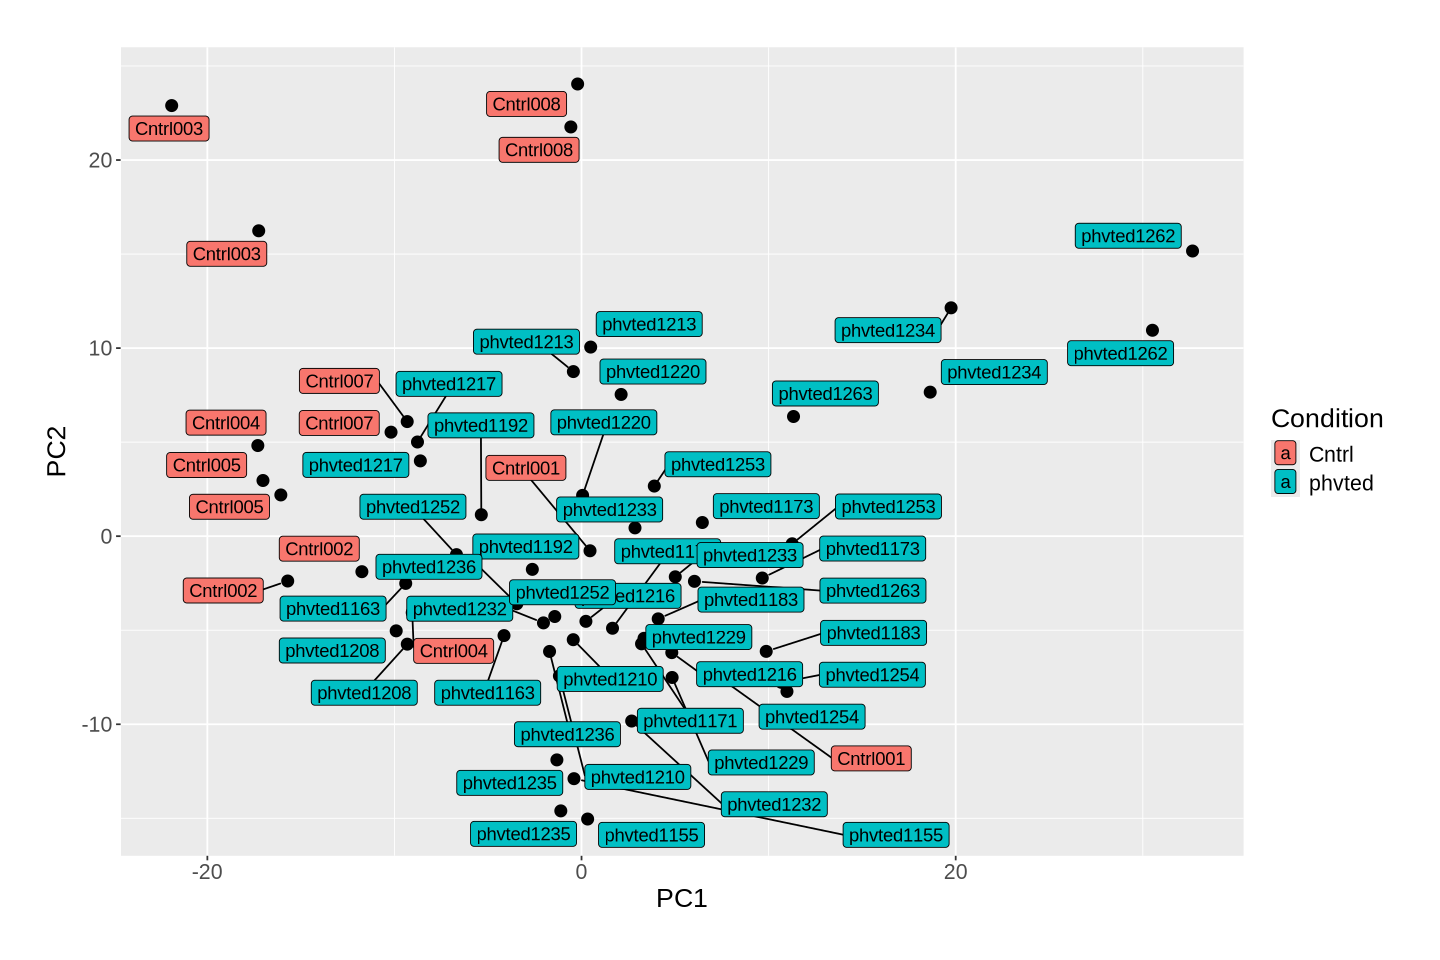

In [125]:
# Create PCA plot with labeling by ID
p <- ggplot(df, aes(x = PC1, y = PC2, label = id,fill = factor(condition))) +
  geom_point(size = 3) +
  ggrepel::geom_label_repel(
    box.padding = 0.35, 
    point.padding = 0.5,  
    max.overlaps = 22
  ) +
  theme_grey() +
  theme(
    text = element_text(size = 16),
    legend.position = "right",
    plot.margin = unit(c(1, 1, 1, 1), "cm"),
    plot.title = element_text(size = 18, face = "bold")
  ) +
  scale_fill_discrete(
    name = "Condition",
    # The same color scall will apply to both of these aesthetics.
    aesthetics = c("fill","segment.color")
  )
options(repr.plot.width = 12, repr.plot.height = 8)
p

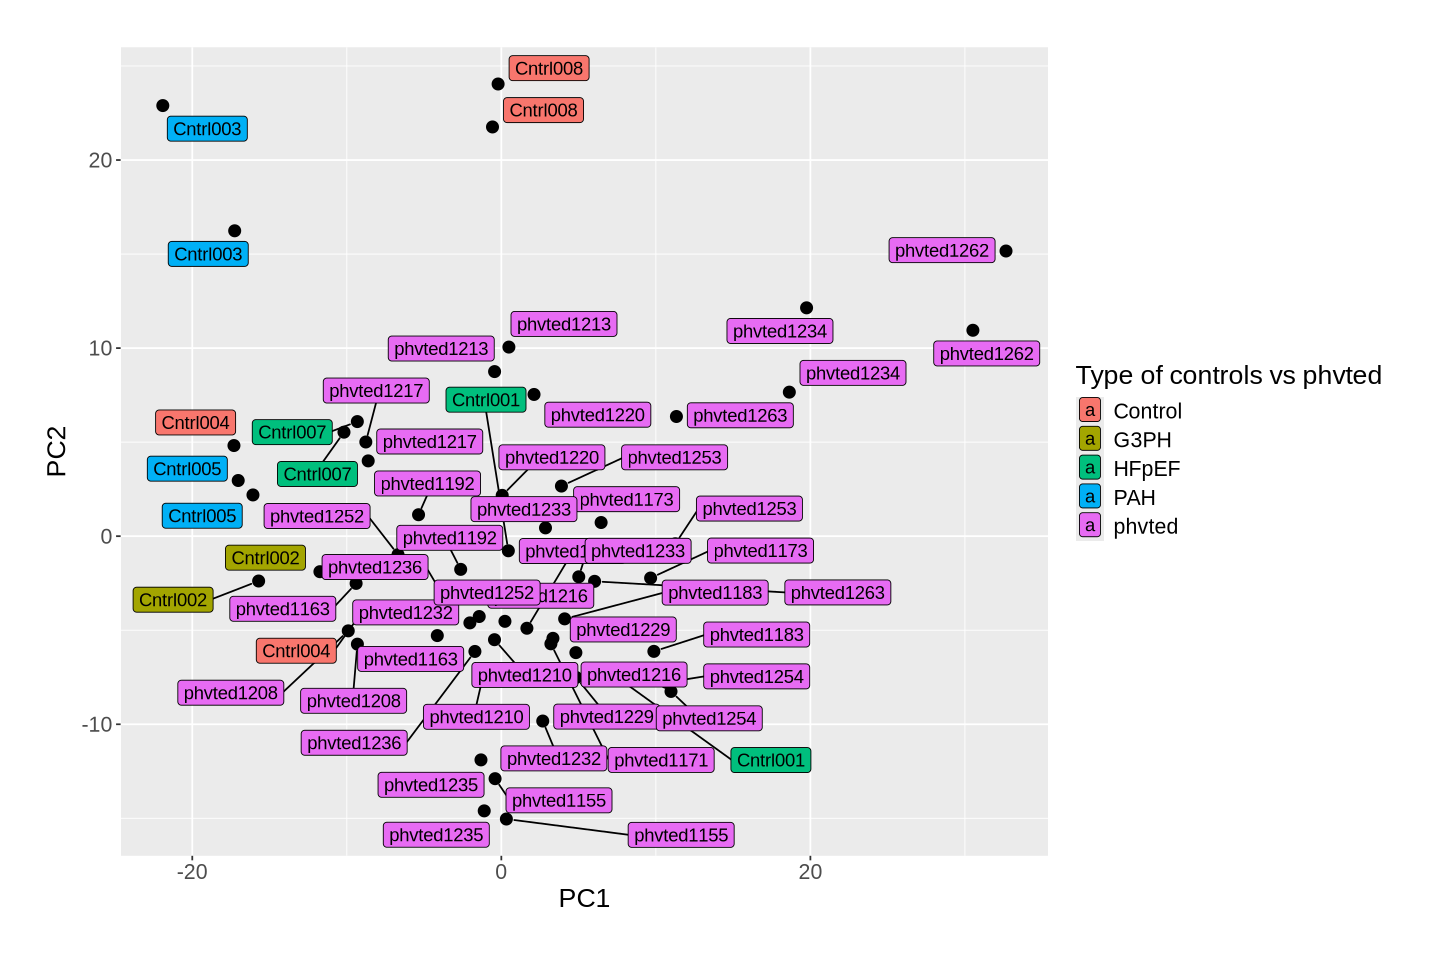

In [122]:
# Create PCA plot with labeling by ID
p <- ggplot(df, aes(x = PC1, y = PC2, label = id,fill = factor(Type_of_Control))) +
  geom_point(size = 3) +
  ggrepel::geom_label_repel(
    box.padding = 0.35, 
    point.padding = 0.5,  
    max.overlaps = 22
  ) +
  theme_grey() +
  theme(
    text = element_text(size = 16),
    legend.position = "right",
    plot.margin = unit(c(1, 1, 1, 1), "cm"),
    plot.title = element_text(size = 18, face = "bold")
  ) +
  scale_fill_discrete(
    name = "Type of controls vs phvted",
    # The same color scall will apply to both of these aesthetics.
    aesthetics = c("fill","segment.color")
  )
options(repr.plot.width = 12, repr.plot.height = 8)
p

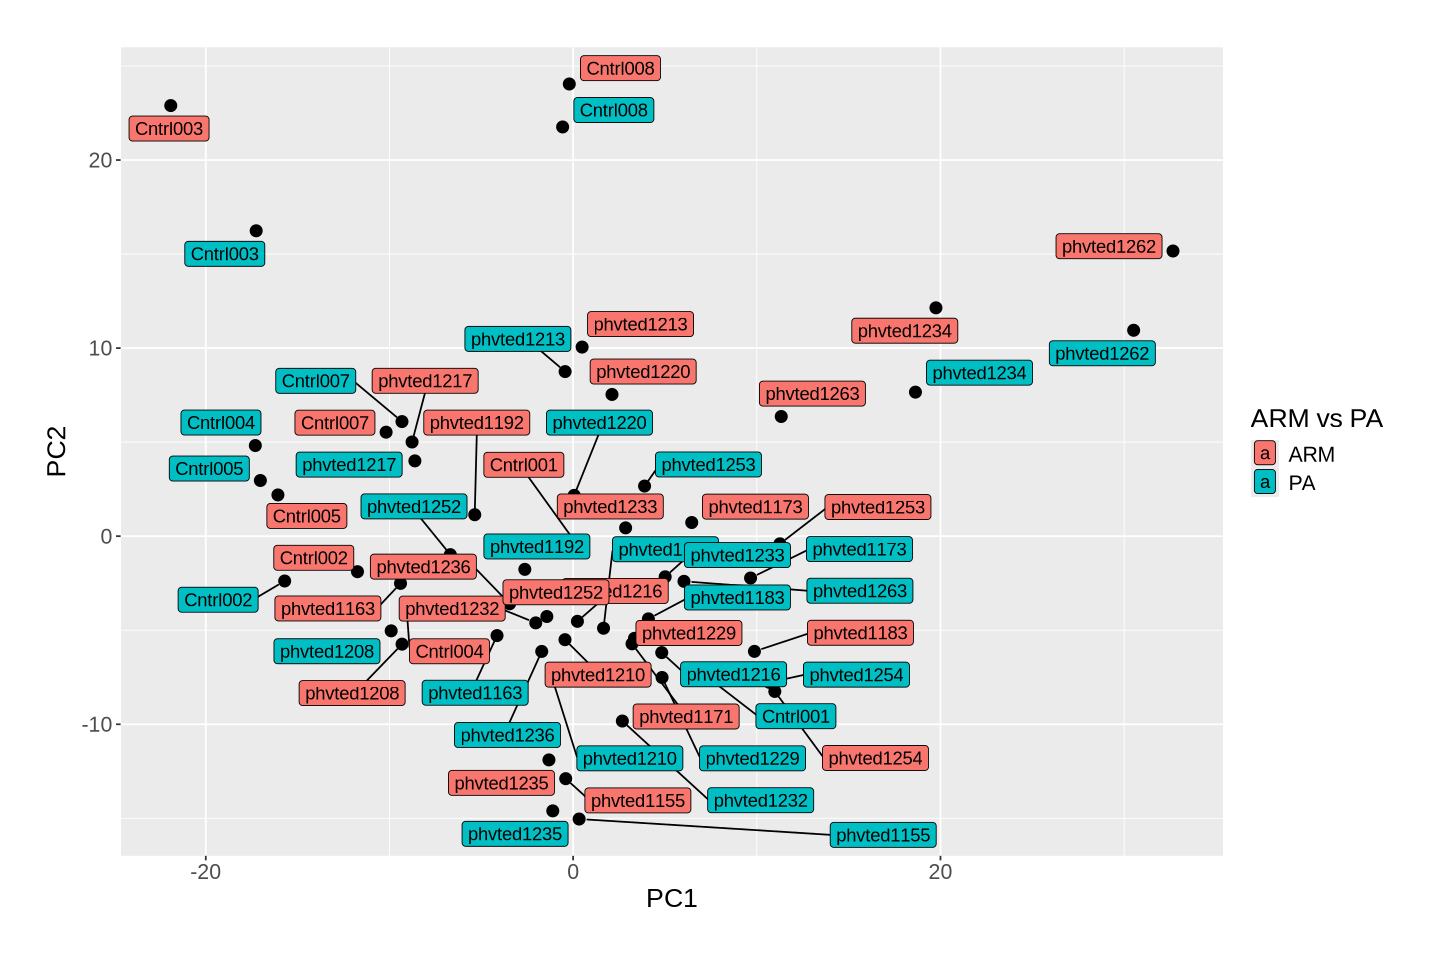

In [124]:
# Create PCA plot with labeling by ID
p <- ggplot(df, aes(x = PC1, y = PC2, label = id,fill = factor(subtype))) +
  geom_point(size = 3) +
  ggrepel::geom_label_repel(
    box.padding = 0.35, 
    point.padding = 0.5,  
    max.overlaps = 22
  ) +
  theme_grey() +
  theme(
    text = element_text(size = 16),
    legend.position = "right",
    plot.margin = unit(c(1, 1, 1, 1), "cm"),
    plot.title = element_text(size = 18, face = "bold")
  ) +
  scale_fill_discrete(
    name = "ARM vs PA",
    aesthetics = c("fill","segment.color")
  )

options(repr.plot.width = 12, repr.plot.height = 8)
p

In [142]:
dds_sub_pvr_3

table(metadata_complete_sub_pvr_3$control_phvted_pvr_comp)

class: DESeqDataSet 
dim: 29744 60 
metadata(1): version
assays(1): counts
rownames(29744): A1BG A1BG-AS1 ... ZZEF1 ZZZ3
rowData names(0):
colnames(60): Cntrl001ARM Cntrl001PA ... phvted1263ARM phvted1263PA
colData names(9): sizeFactor id ... condition control_phvted_pvr_comp


Control_dx_pvr_lesser_3  HFpEF_dx_pvr_greater_3   HFpEF_dx_pvr_lesser_3 
                      4                       2                       2 
                  other    PAH_dx_pvr_greater_3     PAH_dx_pvr_lesser_3 
                      2                       2                       2 
phvted_dx_pvr_greater_3  phvted_dx_pvr_lesser_3 
                     36                      10 

In [158]:
vsd <- vst(dds_sub_pvr_3)
head(assay(vsd), 3)
colData(dds_sub_pvr_3)

,Cntrl001ARM,Cntrl001PA,Cntrl002ARM,Cntrl002PA,Cntrl003ARM,Cntrl003PA,Cntrl004ARM,Cntrl004PA,Cntrl005ARM,Cntrl005PA,⋯,phvted1252ARM,phvted1252PA,phvted1253ARM,phvted1253PA,phvted1254ARM,phvted1254PA,phvted1262ARM,phvted1262PA,phvted1263ARM,phvted1263PA
A1BG,8.079197,8.225318,8.010294,7.829194,7.476366,7.281296,7.248925,7.556240,7.581365,7.765306,⋯,8.084786,7.808210,8.053653,8.216481,7.822582,8.109354,8.335371,8.229346,8.080872,8.299660
A1BG-AS1,7.433228,7.210794,7.664576,7.699926,7.506524,7.334525,7.339472,7.735965,7.120994,7.144178,⋯,7.305926,7.383562,7.381397,7.435618,7.413830,7.592011,7.010427,7.258145,7.163997,7.412987
A1CF,6.876701,6.832877,6.431061,6.755388,6.431061,6.950575,6.648524,6.431061,6.431061,6.648065,⋯,7.085277,6.924037,6.933831,6.651897,6.838720,6.932469,6.842102,6.992793,6.753719,6.838359


DataFrame with 60 rows and 9 columns
              sizeFactor         id  subtype Type_of_Control    dx_pvr
               <numeric>   <factor> <factor>        <factor> <numeric>
Cntrl001ARM     1.084502   Cntrl001      ARM           HFpEF   2.82051
Cntrl001PA      0.890629   Cntrl001      PA            HFpEF   2.82051
Cntrl002ARM     0.954992   Cntrl002      ARM           G3PH    3.00000
Cntrl002PA      0.913424   Cntrl002      PA            G3PH    3.00000
Cntrl003ARM     1.035619   Cntrl003      ARM           PAH     7.60870
...                  ...        ...      ...             ...       ...
phvted1254PA    0.949855 phvted1254      PA           phvted   2.85714
phvted1262ARM   0.709041 phvted1262      ARM          phvted   3.94973
phvted1262PA    0.754862 phvted1262      PA           phvted   3.94973
phvted1263ARM   0.922939 phvted1263      ARM          phvted   2.50000
phvted1263PA    0.866663 phvted1263      PA           phvted   2.50000
                pod_pvr pod_delta_%chang

In [146]:
rld <- vst(dds_sub_pvr_3, blind=T)
rld_mat <- assay(rld)
pca <- prcomp(t(rld_mat))

df <- cbind(metadata_complete_sub_pvr_3, pca$x)

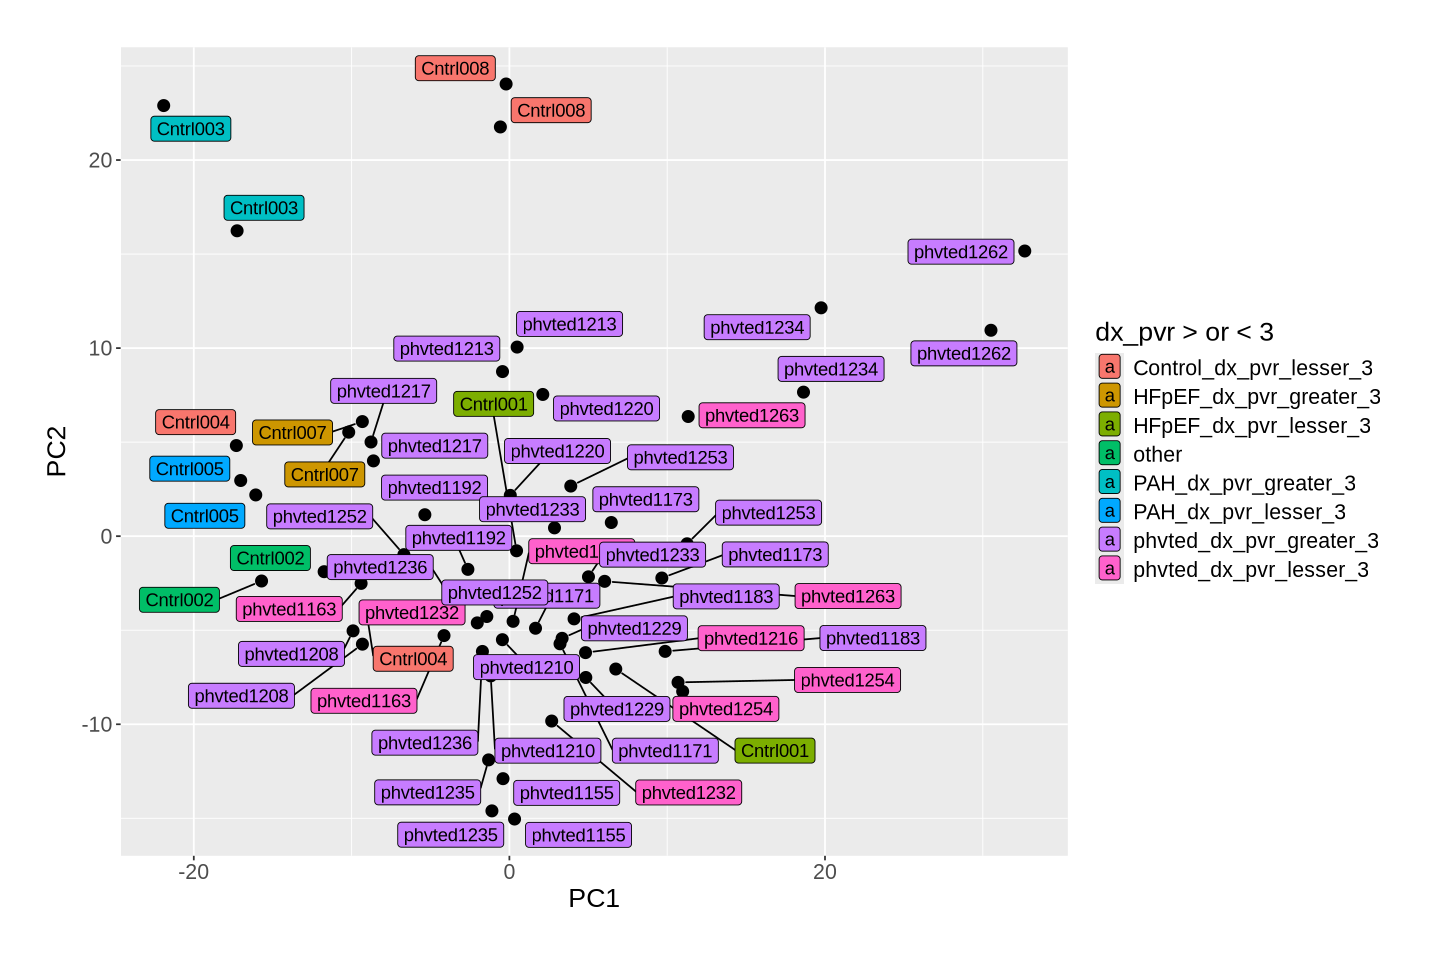

In [147]:
# Create PCA plot with labeling by ID
p <- ggplot(df, aes(x = PC1, y = PC2, label = id,fill = factor(control_phvted_pvr_comp))) +
  geom_point(size = 3) +
  ggrepel::geom_label_repel(
    box.padding = 0.35, 
    point.padding = 0.5,  
    max.overlaps = 22
  ) +
  theme_grey() +
  theme(
    text = element_text(size = 16),
    legend.position = "right",
    plot.margin = unit(c(1, 1, 1, 1), "cm"),
    plot.title = element_text(size = 18, face = "bold")
  ) +
  scale_fill_discrete(
    name = "dx_pvr > or < 3",
    aesthetics = c("fill","segment.color")
  )

options(repr.plot.width = 12, repr.plot.height = 8)
p

In [155]:
metadata_complete_sub_pvr_3 <- metadata_complete_sub %>%
  mutate(control_phvted_pvr_comp=case_when(
    (dx_pvr > 3) ~ "dx_pvr_greater_than_3",
    (dx_pvr < 3) ~ "dx_pvr_lesser_than_3",
    TRUE ~ "dx_pvr_equal_to_3"
  ))

In [156]:
df <- cbind(metadata_complete_sub_pvr_3, pca$x)

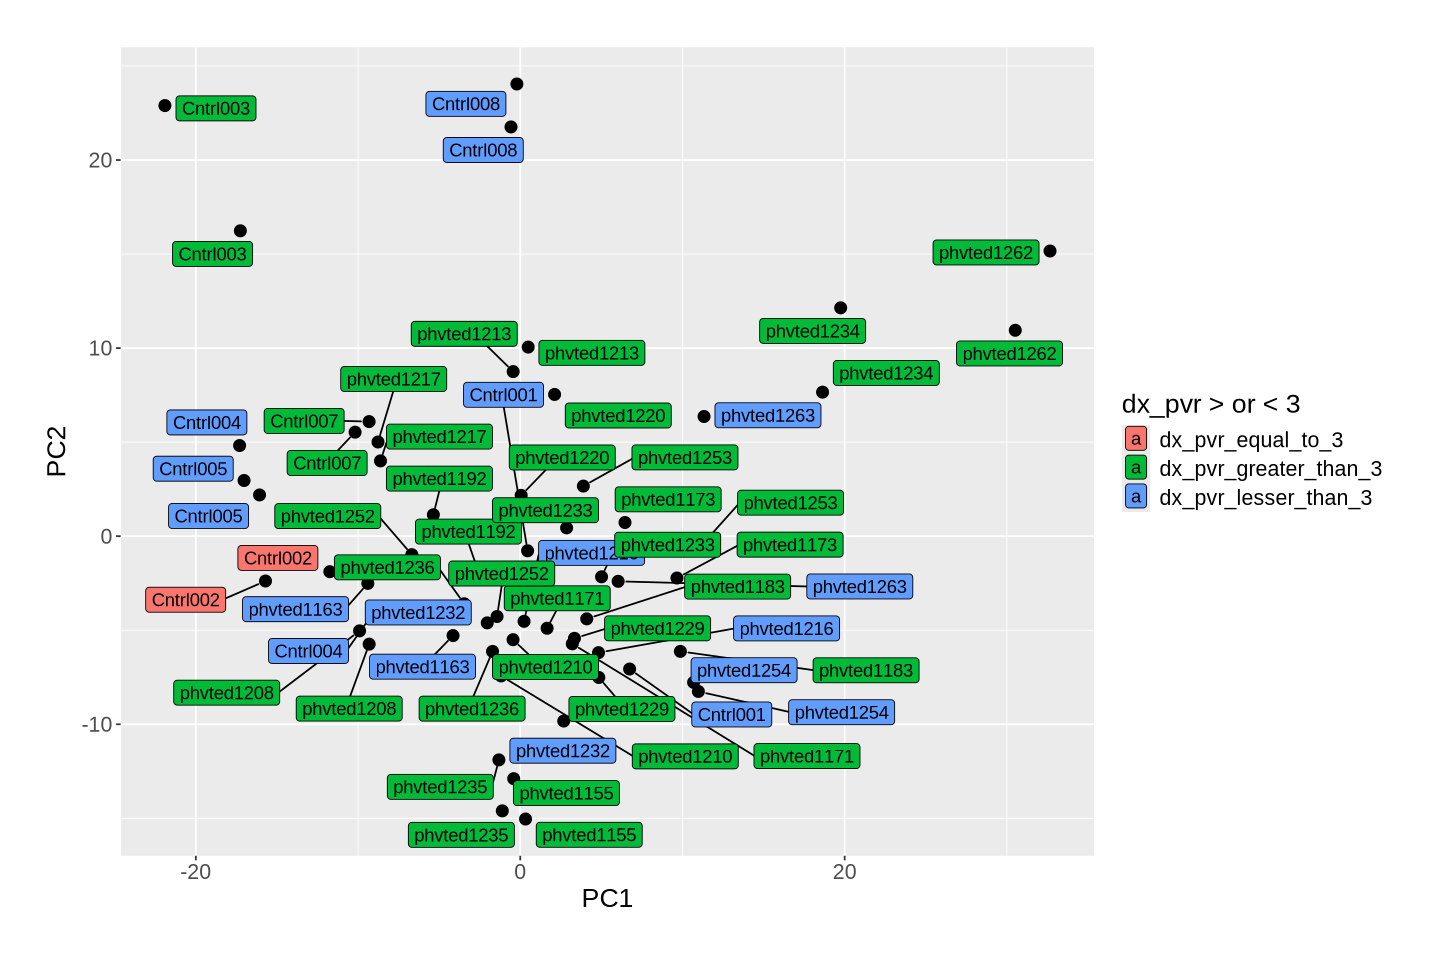

In [157]:
# Create PCA plot with labeling by ID
p <- ggplot(df, aes(x = PC1, y = PC2, label = id,fill = factor(control_phvted_pvr_comp))) +
  geom_point(size = 3) +
  ggrepel::geom_label_repel(
    box.padding = 0.35, 
    point.padding = 0.5,  
    max.overlaps = 22
  ) +
  theme_grey() +
  theme(
    text = element_text(size = 16),
    legend.position = "right",
    plot.margin = unit(c(1, 1, 1, 1), "cm"),
    plot.title = element_text(size = 18, face = "bold")
  ) +
  scale_fill_discrete(
    name = "dx_pvr > or < 3",
    aesthetics = c("fill","segment.color")
  )

options(repr.plot.width = 12, repr.plot.height = 8)
p

# Gene set enrichment analysis

We perform gene set enrichment analysis using clusterprofiler and visualize Pathway crosstalk using enrichplot

In [107]:
library(DOSE)
library(pathview)
library(clusterProfiler)

##############################################################################
Pathview is an open source software package distributed under GNU General
Public License version 3 (GPLv3). Details of GPLv3 is available at
http://www.gnu.org/licenses/gpl-3.0.html. Particullary, users are required to
formally cite the original Pathview paper (not just mention it) in publications
or products. For details, do citation("pathview") within R.

The pathview downloads and uses KEGG data. Non-academic uses may require a KEGG
license agreement (details at http://www.kegg.jp/kegg/legal.html).
##############################################################################



In [108]:
library(AnnotationHub)
library(ensembldb)

Loading required package: BiocFileCache

Loading required package: dbplyr


Attaching package: ‘dbplyr’


The following objects are masked from ‘package:dplyr’:

    ident, sql



Attaching package: ‘AnnotationHub’


The following object is masked from ‘package:Biobase’:

    cache


Loading required package: GenomicFeatures

Loading required package: AnnotationFilter


Attaching package: 'ensembldb'


The following object is masked from 'package:dplyr':

    filter


The following object is masked from 'package:clusterProfiler':

    filter


The following object is masked from 'package:stats':

    filter




In [105]:
# Construct the file path
dir_path <- file.path("~", "b1042-private", "241204_VH01039_361_AACMW53HV", "results")

# Set the working directory
setwd(dir_path)

In [115]:
deg_Control_vs_phvted <- read.csv("deg_Control_vs_phvted_P_threshold_0.05.csv")
deg_HFpEF_vs_phvted <- read.csv("deg_HFpEF_vs_phvted_P_threshold_0.05.csv")
deg_HFpEF_vs_Control <- read.csv("deg_HFpEF_vs_Control_P_threshold_0.05.csv")
deg_PAH_vs_phvted <- read.csv("deg_PAH_vs_phvted_P_threshold_0.05.csv")
deg_PAH_vs_Control <- read.csv("deg_PAH_vs_Control_P_threshold_0.05.csv")
deg_PAH_vs_HFpEF <- read.csv("deg_PAH_vs_HFpEF_P_threshold_0.05.csv")
deg_PA_vs_ARM_0.05 <- read.csv("deg_PA_vs_ARM_P_threshold_0.05.csv")


In [116]:
head(deg_PA_vs_ARM_0.05)

,X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,1,9.2776936,3.601730,2.1661584,1.662727,0.0963670507,0.9997446,TRNAD14
2,2,0.9598814,3.419586,2.9156558,1.172836,0.2408615156,0.9997446,CT47A7
3,3,1.1581455,3.327301,2.9148489,1.141500,0.2536617659,0.9997446,MEF2B
4,4,1.0380358,2.925786,0.7929561,3.689720,0.0002245012,0.8804937,MDS2
5,5,1.2321575,2.845559,1.8400197,1.546483,0.1219880556,0.9997446,TRNAH2
6,6,0.7542161,2.817992,1.6837864,1.673604,0.0942084286,0.9997446,TRNAM4


In [117]:
annotations_ahb <- read.csv("annotations_ahb.csv")
head(annotations_ahb)

,gene_id,gene_name,entrezid,gene_biotype
,<chr>,<chr>,<int>,<chr>
1,ENSG00000223972,DDX11L1,NA,transcribed_unprocessed_pseudogene
2,ENSG00000227232,WASH7P,NA,unprocessed_pseudogene
3,ENSG00000278267,MIR6859-1,NA,miRNA
4,ENSG00000243485,MIR1302-2HG,NA,lncRNA
5,ENSG00000284332,MIR1302-2,NA,miRNA
6,ENSG00000237613,FAM138A,NA,lncRNA


## PA VS ARM

In [176]:
res_ids <- inner_join(deg_PA_vs_ARM_0.05, annotations_ahb, by=c("gene"="gene_id"))

In [177]:
## Create background dataset for hypergeometric testing using all genes tested for significance in the results                 
allOE_genes <- as.character(res_ids$gene)

## Extract significant results
sigOE <- dplyr::filter(res_ids, padj < 0.05)

sigOE_genes <- as.character(sigOE$gene)

In [178]:
sigOE_genes #no SIG genes

character(0)

## PAH_vs_HFpEF

In [188]:
res_ids <- inner_join(deg_PAH_vs_HFpEF, annotations_ahb, by=c("gene"="gene_name"))

In [189]:
## Create background dataset for hypergeometric testing using all genes tested for significance in the results                 
allOE_genes <- as.character(res_ids$gene)

## Extract significant results
sigOE <- dplyr::filter(res_ids, padj < 0.05)

sigOE_genes <- as.character(sigOE$gene)

In [190]:
library(org.Hs.eg.db)
## Run GO enrichment analysis 
ego <- enrichGO(gene = sigOE_genes, 
                universe = allOE_genes,
                keyType = "ENSEMBL",
                OrgDb = org.Hs.eg.db, 
                ont = "BP", 
                pAdjustMethod = "BH", 
                qvalueCutoff = 0.05, 
                readable = TRUE)

--> No gene can be mapped....

--> Expected input gene ID: ENSG00000230678,ENSG00000178222,ENSG00000120669,ENSG00000164120,ENSG00000143569,ENSG00000124092

--> return NULL...



In [191]:
sigOE #Just one significant gene

X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene,gene_id,entrezid,gene_biotype
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<chr>
2,14.09374,21.21914,4.319247,4.912694,8.983356e-07,0.01231169,UBE2F-SCLY,ENSG00000258984,NA,protein_coding


In [192]:
res_ids

X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene,gene_id,entrezid,gene_biotype
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<chr>
2,14.0937379,21.219137,4.319247,4.9126937,8.983356e-07,0.01231169,UBE2F-SCLY,ENSG00000258984,NA,protein_coding
3,59.6223785,9.905699,3.564971,2.7786201,5.459033e-03,1.00000000,SIK1,ENSG00000142178,150094,protein_coding
4,58.6298089,8.026505,3.194084,2.5129285,1.197336e-02,1.00000000,TMEM189-UBE2V1,ENSG00000124208,387522,protein_coding
5,10.5857033,8.014557,4.353808,1.8408153,6.564863e-02,1.00000000,NPIPA7,ENSG00000214967,101059938,protein_coding
10,2.1079852,6.461792,3.068453,2.1058793,3.521484e-02,1.00000000,CKLF-CMTM1,ENSG00000254788,100529251,protein_coding
12,47.6315937,6.065287,1.803730,3.3626353,7.720229e-04,1.00000000,MTRNR2L1,ENSG00000256618,100462977,protein_coding
14,1.4431593,5.860149,4.897564,1.1965436,2.314845e-01,1.00000000,CT47A12,ENSG00000226685,100507170,protein_coding
17,4.8217556,5.677048,4.729567,1.2003315,2.300106e-01,1.00000000,ABHD14A-ACY1,ENSG00000114786,100526760,protein_coding
20,1.1493756,5.532004,7.079700,0.7813896,NA,NA,CTAGE4,ENSG00000225932,100128553,protein_coding


## PHVTED vs Control

In [148]:
deg_phvted_vs_control <- read.csv("deg_phvted_vs_Cntrl.csv")

X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene,gene_id,entrezid,gene_biotype
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<chr>
2,12.861636,4.789655,0.9317283,5.140613,2.738440e-07,6.652394e-05,CTSG,ENSG00000100448,1511,protein_coding
5,4.545962,4.344725,1.4874008,2.921018,3.488895e-03,3.973740e-02,UTS2,ENSG00000049247,10911,protein_coding
8,4.071471,3.972401,0.9433569,4.210920,2.543327e-05,1.673101e-03,ANAPC1P1,ENSG00000233673,NA,transcribed_unprocessed_pseudogene
9,3.000805,3.946570,0.6757152,5.840582,5.201881e-09,3.633361e-06,MS4A3,ENSG00000149516,932,protein_coding
12,3.090660,3.768397,0.8170773,4.612045,3.987265e-06,4.574375e-04,C6orf201,ENSG00000185689,404220,protein_coding
14,69.051649,3.638496,0.8056919,4.515989,6.302179e-06,6.134931e-04,AREG,ENSG00000109321,374,protein_coding
17,3.316117,3.448597,0.6709533,5.139847,2.749617e-07,6.652394e-05,FOXI2,ENSG00000186766,399823,protein_coding
19,2.812434,3.417130,0.7573045,4.512227,6.415035e-06,6.192856e-04,ANO7,ENSG00000146205,50636,protein_coding
20,2.091299,3.414581,0.7390048,4.620513,3.827931e-06,4.434424e-04,VMO1,ENSG00000182853,284013,protein_coding


X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene,gene_id,entrezid,gene_biotype
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<chr>
2,12.861636,4.789655,0.9317283,5.140613,2.738440e-07,6.652394e-05,CTSG,ENSG00000100448,1511,protein_coding
5,4.545962,4.344725,1.4874008,2.921018,3.488895e-03,3.973740e-02,UTS2,ENSG00000049247,10911,protein_coding
7,2.635149,4.192654,1.8033485,2.324927,2.007586e-02,1.148934e-01,TSPY3,ENSG00000228927,728137,protein_coding
8,4.071471,3.972401,0.9433569,4.210920,2.543327e-05,1.673101e-03,ANAPC1P1,ENSG00000233673,NA,transcribed_unprocessed_pseudogene
9,3.000805,3.946570,0.6757152,5.840582,5.201881e-09,3.633361e-06,MS4A3,ENSG00000149516,932,protein_coding
11,2.123079,3.882169,3.4566127,1.123114,2.613892e-01,5.035671e-01,TBC1D3F,ENSG00000275954,84218,protein_coding
12,3.090660,3.768397,0.8170773,4.612045,3.987265e-06,4.574375e-04,C6orf201,ENSG00000185689,404220,protein_coding
14,69.051649,3.638496,0.8056919,4.515989,6.302179e-06,6.134931e-04,AREG,ENSG00000109321,374,protein_coding
17,3.316117,3.448597,0.6709533,5.139847,2.749617e-07,6.652394e-05,FOXI2,ENSG00000186766,399823,protein_coding


preparing gene to GO mapping data...

preparing IC data...



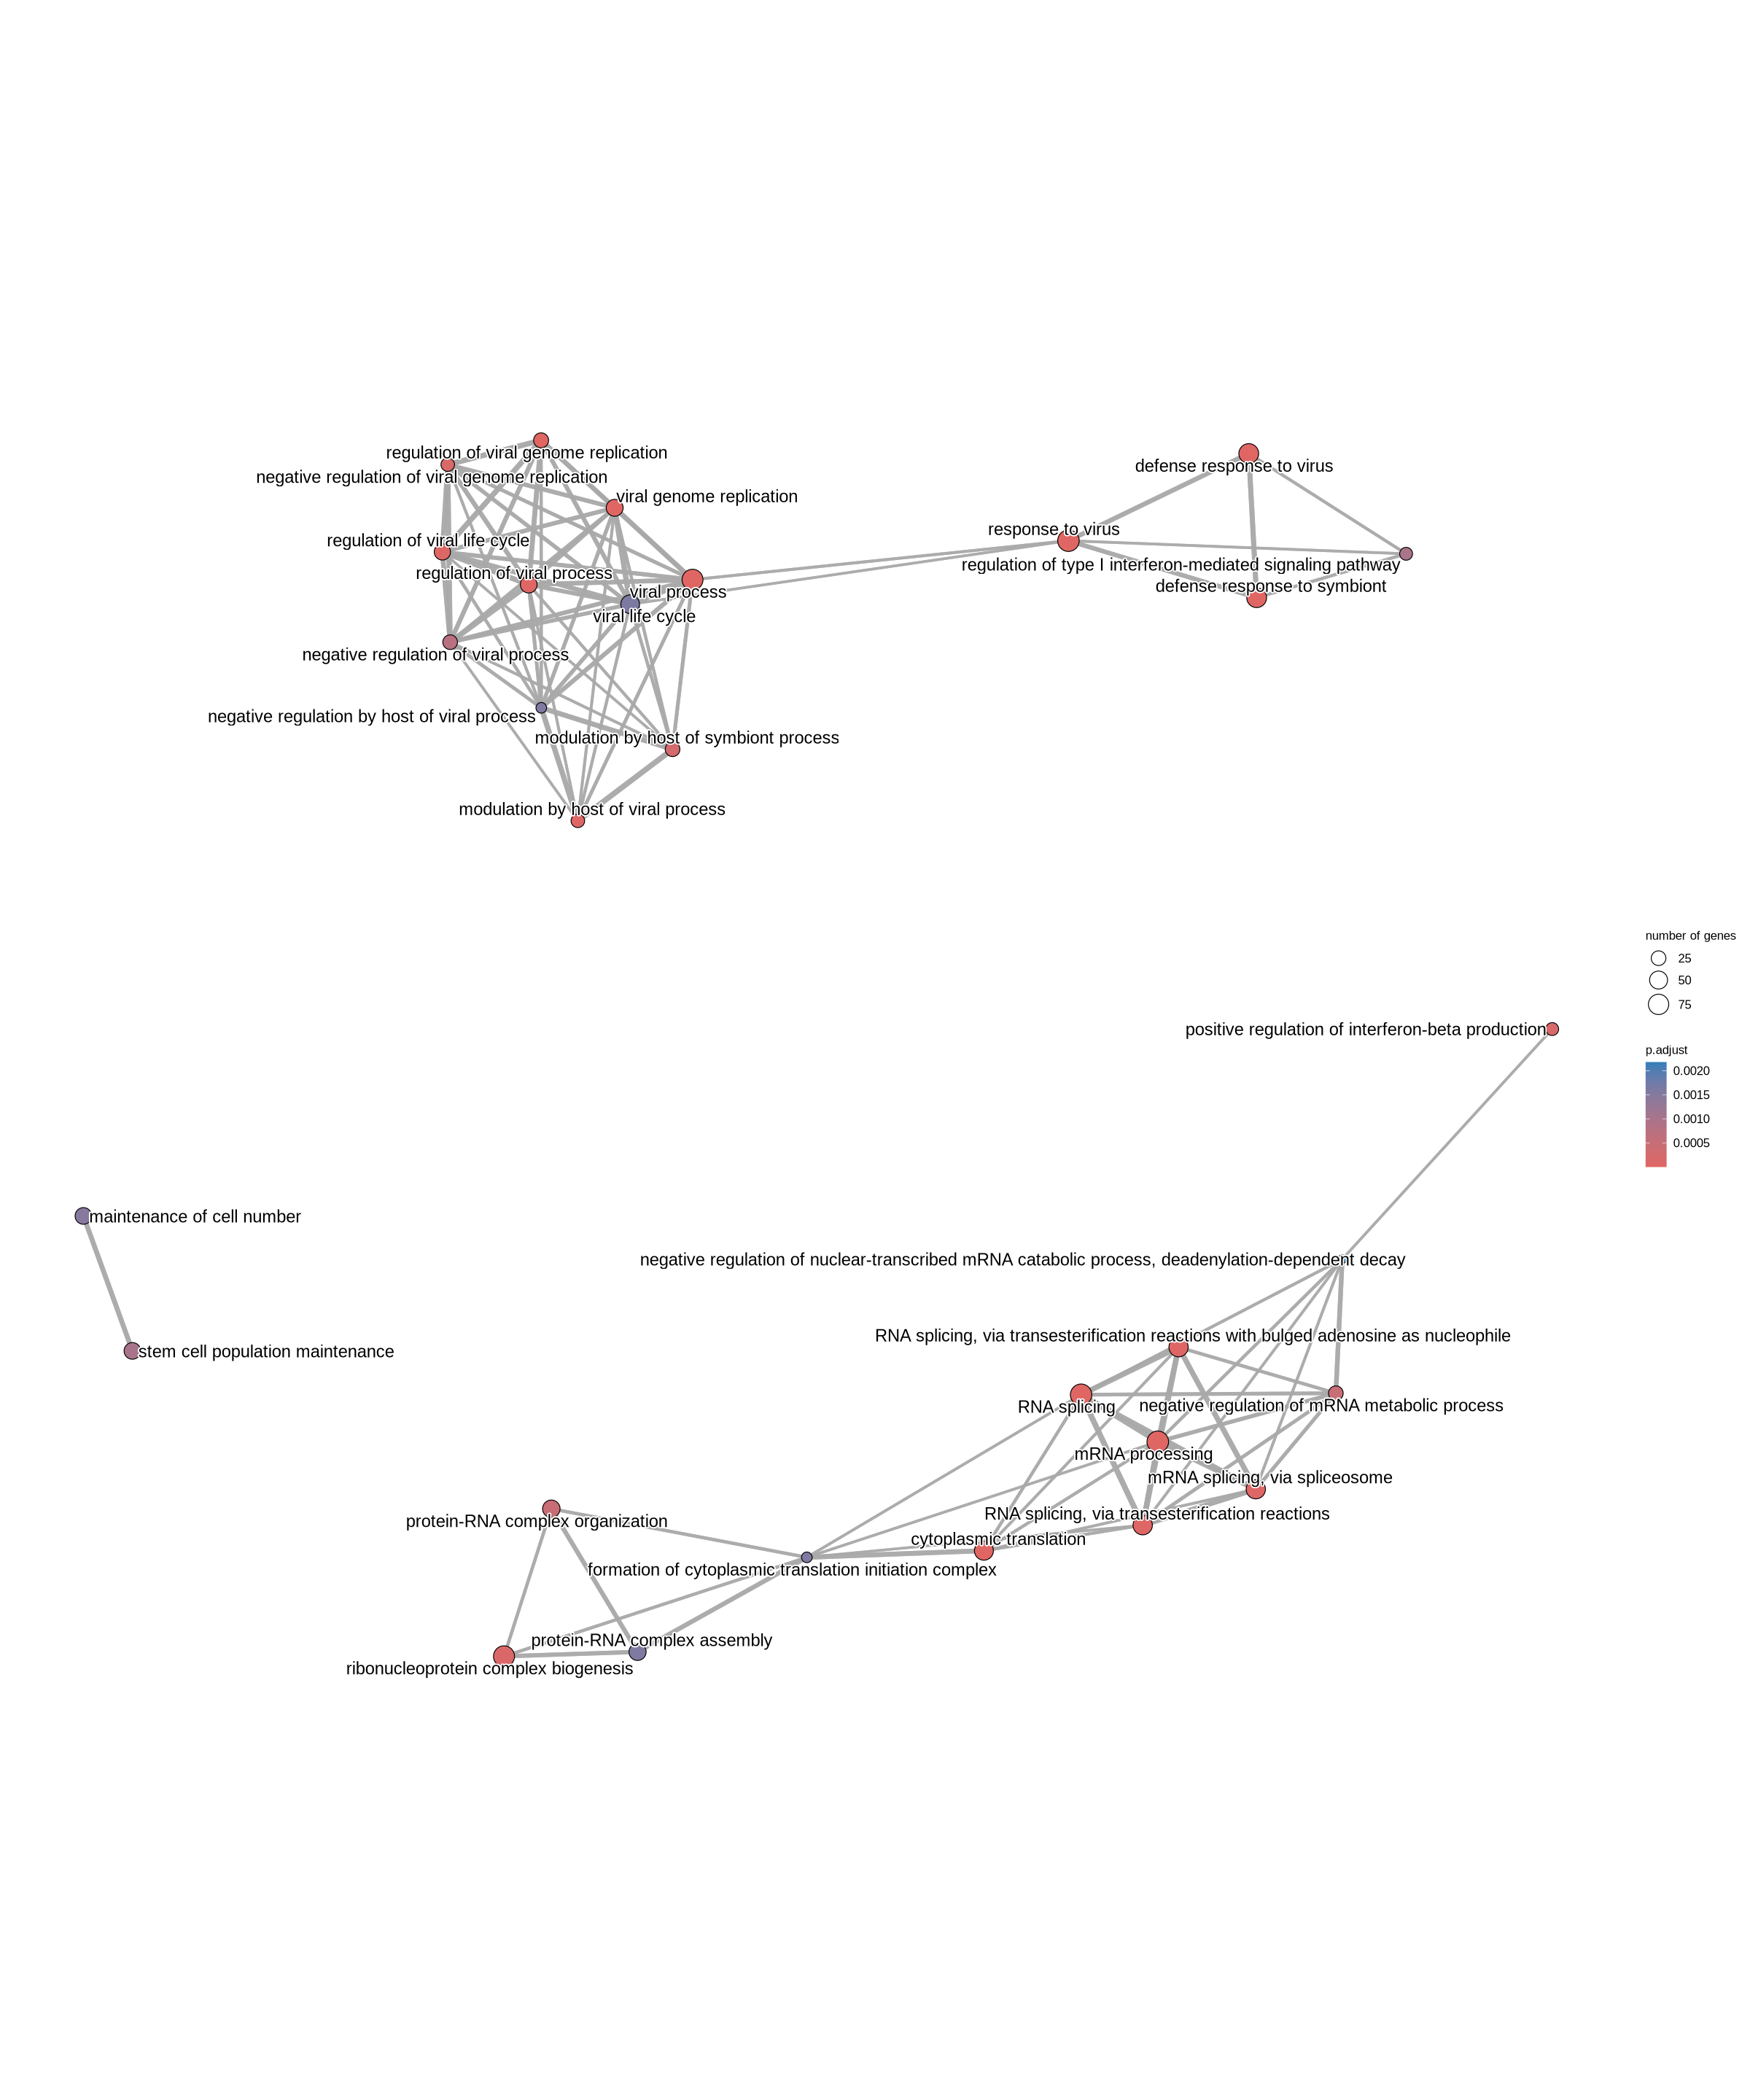

In [149]:
res_ids <- inner_join(deg_phvted_vs_control, annotations_ahb, by=c("gene"="gene_name"))

## Create background dataset for hypergeometric testing using all genes tested for significance in the results                 
allOE_genes <- as.character(res_ids$gene_id)

## Extract significant results
sigOE <- dplyr::filter(res_ids, padj < 0.05)

sigOE_genes <- as.character(sigOE$gene_id)

library(org.Hs.eg.db)
## Run GO enrichment analysis 
ego <- enrichGO(gene = sigOE_genes, 
                universe = allOE_genes,
                keyType = "ENSEMBL",
                OrgDb = org.Hs.eg.db, 
                ont = "BP", 
                pAdjustMethod = "BH", 
                qvalueCutoff = 0.05, 
                readable = TRUE)

sigOE

res_ids

#enrichment map plot for cellular crosstalk - nodes are pathways, edges represent shared genes / crosstalk
d <- godata('org.Hs.eg.db', ont="BP")
ego2 <- pairwise_termsim(ego, method="Wang", semData = d)
emapplot(ego2)


preparing gene to GO mapping data...

preparing IC data...



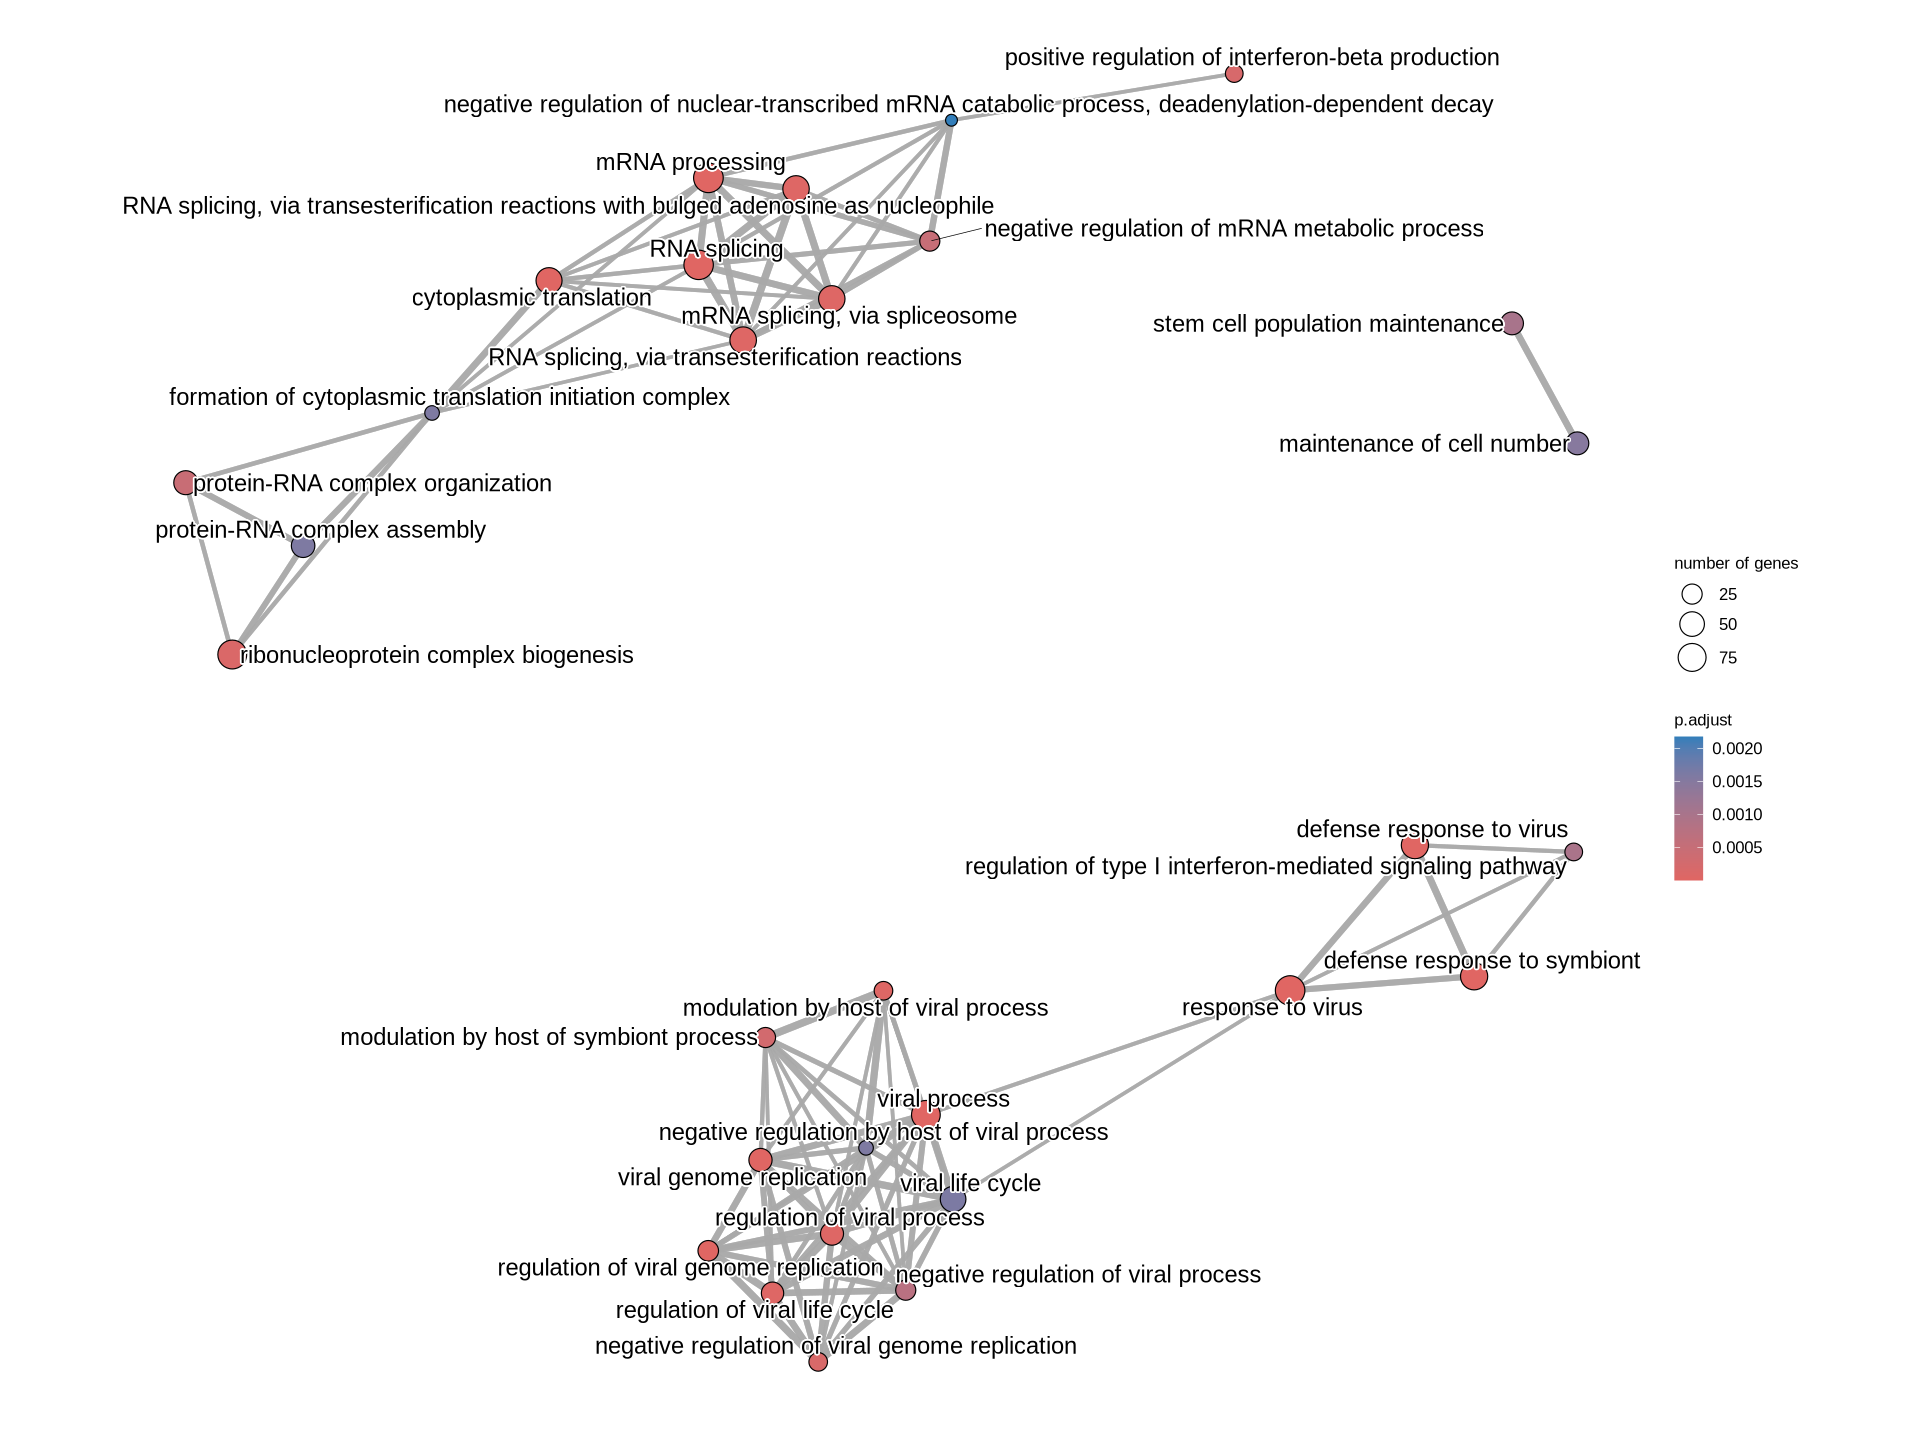

In [150]:
d <- godata('org.Hs.eg.db', ont="BP")
ego2 <- pairwise_termsim(ego, method="Wang", semData = d)
p<-emapplot(ego2)
options(repr.plot.width = 16, repr.plot.height = 12)
p

In [151]:
ggsave(p, 
       filename = "GO_enrichment_plot_phvted_vs_Cntrl.pdf",
       device = "pdf",
       height = 20, width = 24, units = "in")

In [251]:
res_ids

X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene,gene_id,entrezid,gene_biotype
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<chr>
2,12.861636,4.789655,0.9317283,5.140613,2.738440e-07,6.652394e-05,CTSG,ENSG00000100448,1511,protein_coding
5,4.545962,4.344725,1.4874008,2.921018,3.488895e-03,3.973740e-02,UTS2,ENSG00000049247,10911,protein_coding
7,2.635149,4.192654,1.8033485,2.324927,2.007586e-02,1.148934e-01,TSPY3,ENSG00000228927,728137,protein_coding
8,4.071471,3.972401,0.9433569,4.210920,2.543327e-05,1.673101e-03,ANAPC1P1,ENSG00000233673,NA,transcribed_unprocessed_pseudogene
9,3.000805,3.946570,0.6757152,5.840582,5.201881e-09,3.633361e-06,MS4A3,ENSG00000149516,932,protein_coding
11,2.123079,3.882169,3.4566127,1.123114,2.613892e-01,5.035671e-01,TBC1D3F,ENSG00000275954,84218,protein_coding
12,3.090660,3.768397,0.8170773,4.612045,3.987265e-06,4.574375e-04,C6orf201,ENSG00000185689,404220,protein_coding
14,69.051649,3.638496,0.8056919,4.515989,6.302179e-06,6.134931e-04,AREG,ENSG00000109321,374,protein_coding
17,3.316117,3.448597,0.6709533,5.139847,2.749617e-07,6.652394e-05,FOXI2,ENSG00000186766,399823,protein_coding


In [252]:
sigOE

X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene,gene_id,entrezid,gene_biotype
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<chr>
2,12.861636,4.789655,0.9317283,5.140613,2.738440e-07,6.652394e-05,CTSG,ENSG00000100448,1511,protein_coding
5,4.545962,4.344725,1.4874008,2.921018,3.488895e-03,3.973740e-02,UTS2,ENSG00000049247,10911,protein_coding
8,4.071471,3.972401,0.9433569,4.210920,2.543327e-05,1.673101e-03,ANAPC1P1,ENSG00000233673,NA,transcribed_unprocessed_pseudogene
9,3.000805,3.946570,0.6757152,5.840582,5.201881e-09,3.633361e-06,MS4A3,ENSG00000149516,932,protein_coding
12,3.090660,3.768397,0.8170773,4.612045,3.987265e-06,4.574375e-04,C6orf201,ENSG00000185689,404220,protein_coding
14,69.051649,3.638496,0.8056919,4.515989,6.302179e-06,6.134931e-04,AREG,ENSG00000109321,374,protein_coding
17,3.316117,3.448597,0.6709533,5.139847,2.749617e-07,6.652394e-05,FOXI2,ENSG00000186766,399823,protein_coding
19,2.812434,3.417130,0.7573045,4.512227,6.415035e-06,6.192856e-04,ANO7,ENSG00000146205,50636,protein_coding
20,2.091299,3.414581,0.7390048,4.620513,3.827931e-06,4.434424e-04,VMO1,ENSG00000182853,284013,protein_coding


In [253]:
ego

#
# over-representation test
#
#...@organism 	 Homo sapiens 
#...@ontology 	 BP 
#...@keytype 	 ENSEMBL 
#...@gene 	 chr [1:2067] "ENSG00000100448" "ENSG00000049247" "ENSG00000233673" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...127 enriched terms found
'data.frame':	127 obs. of  9 variables:
 $ ID         : chr  "GO:0002181" "GO:0019079" "GO:0009615" "GO:0008380" ...
 $ Description: chr  "cytoplasmic translation" "viral genome replication" "response to virus" "RNA splicing" ...
 $ GeneRatio  : chr  "60/1762" "41/1762" "89/1762" "88/1762" ...
 $ BgRatio    : chr  "152/17073" "124/17073" "423/17073" "450/17073" ...
 $ pvalue     : num  2.42e-21 4.96e-12 3.62e-11 2.29e-09 2.63e-09 ...
 $ p.adjust   : num  1.42e-17 1.45e-08 7.06e-08 2.94e-06 2.94e-06 ...
 $ qvalue     : num  1.30e-17 1.33e-08 6.49e-08 2.70e-06 2.70e-06 ...
 $ geneID     : chr  "LIN28A/IGF2BP1/RPS24/RPL5/RPL24/RPS2/RPL26/RWDD1/EIF3C/RPL21/RPL9/ZC3H15/PABPC1/RPL3/RPL34/RPL6/EIF3L/RPS8/EIF2"| __truncated__ "LTF/VA

In [208]:
cluster_summary <- data.frame(ego)
cluster_summary
write.csv(cluster_summary, "clusterProfiler_PHVTED vs Control.csv")

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0002181,GO:0002181,cytoplasmic translation,60/1762,152/17073,2.424666e-21,1.417702e-17,1.303450e-17,LIN28A/IGF2BP1/RPS24/RPL5/RPL24/RPS2/RPL26/RWDD1/EIF3C/RPL21/RPL9/ZC3H15/PABPC1/RPL3/RPL34/RPL6/EIF3L/RPS8/EIF2S2/RPL36A/RPS5/EIF3E/RPL22/RPL15/RPS3A/RPS16/DHX29/RPL39/EIF3J/EIF3H/YBX1/RPL7/RPL10A/RPS27/RPL26L1/RPL23A/RPL32/RPLP1/RPL7A/EIF4A2/RPL11/RPS11/HNRNPU/SYNCRIP/DENR/EIF2S3/RPL14/RPS20/FAU/SH3BGRL/RPL35A/RPLP2/RPL36/EIF3D/EIF3A/EIF3M/DHX9/HNRNPD/ZNF385A/RPS29,60
GO:0019079,GO:0019079,viral genome replication,41/1762,124/17073,4.955145e-12,1.448637e-08,1.331891e-08,LTF/VAPA/SMC5/DEK/PABPC1/EEF1A1/NUCKS1/PPIE/HTATSF1/LAMTOR5/SMC6/DDX5/ILF3/TOP2B/INPP5K/TRIM38/TBC1D20/NOTCH1/CCNK/STOM/APOBEC3C/ZC3HAV1/ZNFX1/ZFYVE1/ADAR/IFIT5/OAS1/ADARB1/ISG20/IFIH1/EIF2AK2/OASL/ISG15/OAS2/MX1/OAS3/IFIT1/CCL8/RSAD2/CCL2/APOBEC3H,41
GO:0009615,GO:0009615,response to virus,89/1762,423/17073,3.620070e-11,7.055516e-08,6.486911e-08,MST1R/IL6/IFNL4/MID2/DMBT1/POLR3G/CDK6/HIF1A/AKAP1/EEF1G/IVNS1ABP/AIMP1/DDX21/TPT1/LAMTOR5/HSP90AA1/URI1/DNAJC3/ENO1/CCT5/SAP30BP/ILF3/PQBP1/DHX9/TYK2/ATG7/IRF3/TRIM38/IRF5/NT5C2/STING1/SPN/MAP3K14/TRIM25/UNC13D/GBF1/POLR3A/IL17RA/LYST/APOBEC3C/MAPK14/UNC93B1/ZC3HAV1/TRIM56/ZNFX1/POU2F2/TREX1/IRF9/DDX60L/ADAR/TICAM1/SMAD3/LGALS9/TRIM5/SLFN13/STAT2/DTX3L/IFIT5/OAS1/MOV10/PML/ADARB1/PARP9/ISG20/RIGI/RTP4/DDX60/IFIH1/DHX58/IRF7/EIF2AK2/MX2/ZBP1/OASL/IFI44/HERC5/ISG15/IFIT2/OAS2/MX1/OAS3/IFI6/IFIT3/IFIT1/CCL8/IFI44L/RSAD2/USP18/APOBEC3H,89
GO:0008380,GO:0008380,RNA splicing,88/1762,450/17073,2.287352e-09,2.938526e-06,2.701710e-06,RBMXL3/SLC39A5/HOXB-AS3/CELF3/RBFOX1/THOC5/RP9/NPM1/FRA10AC1/IVNS1ABP/ARB2A/ENY2/SNRPD1/SREK1IP1/FRG1/CWC15/PABPC1/PNN/C2orf49/HNRNPA3/PPIE/FXR1/HNRNPA1/PPIG/RBM39/HTATSF1/FAM50A/STRAP/DDX46/HNRNPC/TAF15/ZNF326/LSM3/HNRNPR/HNRNPH3/CWC25/SNRNP27/PRPF4B/SNRPG/PSIP1/RSRC1/LUC7L2/YBX1/NCL/ARL6IP4/SRRM1/TXNL4A/CWC27/NONO/ZMAT2/TCERG1/RBM17/HNRNPU/PRPF38A/C9orf78/SYNCRIP/SRSF9/RBMX/HNRNPH1/SMNDC1/HNRNPA2B1/HNRNPM/DDX5/TAF12/PPP4R2/PQBP1/THRAP3/WTAP/PRPF40A/DHX9/KHDRBS1/SNRNP200/HNRNPK/RBM42/DHX8/TRRAP/SF3A2/SF3B3/XAB2/SF3B4/PHF5A/RBM12B/SCAF1/SRSF7/PPIL2/FAM98B/POLR2A/ARMC7,88
GO:0051607,GO:0051607,defense response to virus,69/1762,322/17073,2.630873e-09,2.938526e-06,2.701710e-06,IL6/IFNL4/MID2/DMBT1/POLR3G/AKAP1/AIMP1/DDX21/HSP90AA1/DNAJC3/ILF3/PQBP1/DHX9/ATG7/IRF3/TRIM38/IRF5/NT5C2/STING1/SPN/MAP3K14/TRIM25/UNC13D/POLR3A/LYST/APOBEC3C/UNC93B1/ZC3HAV1/TRIM56/ZNFX1/TREX1/IRF9/DDX60L/ADAR/TICAM1/TRIM5/SLFN13/STAT2/DTX3L/IFIT5/OAS1/MOV10/PML/ADARB1/PARP9/ISG20/RIGI/RTP4/DDX60/IFIH1/DHX58/IRF7/EIF2AK2/MX2/ZBP1/OASL/HERC5/ISG15/IFIT2/OAS2/MX1/OAS3/IFI6/IFIT3/IFIT1/IFI44L/RSAD2/USP18/APOBEC3H,69
GO:0140546,GO:0140546,defense response to symbiont,69/1762,323/17073,3.015419e-09,2.938526e-06,2.701710e-06,IL6/IFNL4/MID2/DMBT1/POLR3G/AKAP1/AIMP1/DDX21/HSP90AA1/DNAJC3/ILF3/PQBP1/DHX9/ATG7/IRF3/TRIM38/IRF5/NT5C2/STING1/SPN/MAP3K14/TRIM25/UNC13D/POLR3A/LYST/APOBEC3C/UNC93B1/ZC3HAV1/TRIM56/ZNFX1/TREX1/IRF9/DDX60L/ADAR/TICAM1/TRIM5/SLFN13/STAT2/DTX3L/IFIT5/OAS1/MOV10/PML/ADARB1/PARP9/ISG20/RIGI/RTP4/DDX60/IFIH1/DHX58/IRF7/EIF2AK2/MX2/ZBP1/OASL/HERC5/ISG15/IFIT2/OAS2/MX1/OAS3/IFI6/IFIT3/IFIT1/IFI44L/RSAD2/USP18/APOBEC3H,69
GO:0016032,GO:0016032,viral process,82/1762,414/17073,4.383660e-09,3.661609e-06,3.366519e-06,LTF/RFPL3/MID2/CDK1/CR2/ST6GALNAC3/VAPA/SMC5/DEK/PABPC1/EEF1A1/NUCKS1/PPIE/HTATSF1/EIF3L/HMGB1/SNX3/HSP90AB1/LAMTOR5/CALCOCO2/SMC6/VPS37B/CHMP1B/HDAC1/CANX/SPCS3/DENR/PSMC3/DDX5/ILF3/EIF3D/TOP2B/EIF3A/DHX9/MGAT1/EP300/SP1/SELPLG/MOGS/RNASEK/INPP5K/TRIM38/CSF1R/TBC1D20/GSK3A/HCFC1/EDEM2/USF1/NOTCH1/TRIM25/CCNK/STOM/APOBEC3C/ZC3HAV1/ZNFX1/ZFYVE1/PARP10/ST3GAL2/ADAR/LGALS9/HEXIM1/TRIM5/IFIT5/OAS1/ADARB1/PARP9/ISG20/IFIH1/IRF7/EIF2AK2/OASL/ISG15/OAS2/MX1/OAS3/LY6E/IFIT1/CCL8/RSAD2/SIGLEC1/CCL2/APOBEC3H,82
GO:0006397,GO:0006397,mRNA processing,90/1762,480/17073,1.280566e-08,8.319555e-06,7.

In [233]:
ego

#
# over-representation test
#
#...@organism 	 Homo sapiens 
#...@ontology 	 BP 
#...@keytype 	 ENSEMBL 
#...@gene 	 chr [1:2067] "ENSG00000100448" "ENSG00000049247" "ENSG00000233673" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...127 enriched terms found
'data.frame':	127 obs. of  9 variables:
 $ ID         : chr  "GO:0002181" "GO:0019079" "GO:0009615" "GO:0008380" ...
 $ Description: chr  "cytoplasmic translation" "viral genome replication" "response to virus" "RNA splicing" ...
 $ GeneRatio  : chr  "60/1762" "41/1762" "89/1762" "88/1762" ...
 $ BgRatio    : chr  "152/17073" "124/17073" "423/17073" "450/17073" ...
 $ pvalue     : num  2.42e-21 4.96e-12 3.62e-11 2.29e-09 2.63e-09 ...
 $ p.adjust   : num  1.42e-17 1.45e-08 7.06e-08 2.94e-06 2.94e-06 ...
 $ qvalue     : num  1.30e-17 1.33e-08 6.49e-08 2.70e-06 2.70e-06 ...
 $ geneID     : chr  "LIN28A/IGF2BP1/RPS24/RPL5/RPL24/RPS2/RPL26/RWDD1/EIF3C/RPL21/RPL9/ZC3H15/PABPC1/RPL3/RPL34/RPL6/EIF3L/RPS8/EIF2"| __truncated__ "LTF/VA

In [235]:
cluster_summary

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0002181,GO:0002181,cytoplasmic translation,60/1762,152/17073,2.424666e-21,1.417702e-17,1.303450e-17,LIN28A/IGF2BP1/RPS24/RPL5/RPL24/RPS2/RPL26/RWDD1/EIF3C/RPL21/RPL9/ZC3H15/PABPC1/RPL3/RPL34/RPL6/EIF3L/RPS8/EIF2S2/RPL36A/RPS5/EIF3E/RPL22/RPL15/RPS3A/RPS16/DHX29/RPL39/EIF3J/EIF3H/YBX1/RPL7/RPL10A/RPS27/RPL26L1/RPL23A/RPL32/RPLP1/RPL7A/EIF4A2/RPL11/RPS11/HNRNPU/SYNCRIP/DENR/EIF2S3/RPL14/RPS20/FAU/SH3BGRL/RPL35A/RPLP2/RPL36/EIF3D/EIF3A/EIF3M/DHX9/HNRNPD/ZNF385A/RPS29,60
GO:0019079,GO:0019079,viral genome replication,41/1762,124/17073,4.955145e-12,1.448637e-08,1.331891e-08,LTF/VAPA/SMC5/DEK/PABPC1/EEF1A1/NUCKS1/PPIE/HTATSF1/LAMTOR5/SMC6/DDX5/ILF3/TOP2B/INPP5K/TRIM38/TBC1D20/NOTCH1/CCNK/STOM/APOBEC3C/ZC3HAV1/ZNFX1/ZFYVE1/ADAR/IFIT5/OAS1/ADARB1/ISG20/IFIH1/EIF2AK2/OASL/ISG15/OAS2/MX1/OAS3/IFIT1/CCL8/RSAD2/CCL2/APOBEC3H,41
GO:0009615,GO:0009615,response to virus,89/1762,423/17073,3.620070e-11,7.055516e-08,6.486911e-08,MST1R/IL6/IFNL4/MID2/DMBT1/POLR3G/CDK6/HIF1A/AKAP1/EEF1G/IVNS1ABP/AIMP1/DDX21/TPT1/LAMTOR5/HSP90AA1/URI1/DNAJC3/ENO1/CCT5/SAP30BP/ILF3/PQBP1/DHX9/TYK2/ATG7/IRF3/TRIM38/IRF5/NT5C2/STING1/SPN/MAP3K14/TRIM25/UNC13D/GBF1/POLR3A/IL17RA/LYST/APOBEC3C/MAPK14/UNC93B1/ZC3HAV1/TRIM56/ZNFX1/POU2F2/TREX1/IRF9/DDX60L/ADAR/TICAM1/SMAD3/LGALS9/TRIM5/SLFN13/STAT2/DTX3L/IFIT5/OAS1/MOV10/PML/ADARB1/PARP9/ISG20/RIGI/RTP4/DDX60/IFIH1/DHX58/IRF7/EIF2AK2/MX2/ZBP1/OASL/IFI44/HERC5/ISG15/IFIT2/OAS2/MX1/OAS3/IFI6/IFIT3/IFIT1/CCL8/IFI44L/RSAD2/USP18/APOBEC3H,89
GO:0008380,GO:0008380,RNA splicing,88/1762,450/17073,2.287352e-09,2.938526e-06,2.701710e-06,RBMXL3/SLC39A5/HOXB-AS3/CELF3/RBFOX1/THOC5/RP9/NPM1/FRA10AC1/IVNS1ABP/ARB2A/ENY2/SNRPD1/SREK1IP1/FRG1/CWC15/PABPC1/PNN/C2orf49/HNRNPA3/PPIE/FXR1/HNRNPA1/PPIG/RBM39/HTATSF1/FAM50A/STRAP/DDX46/HNRNPC/TAF15/ZNF326/LSM3/HNRNPR/HNRNPH3/CWC25/SNRNP27/PRPF4B/SNRPG/PSIP1/RSRC1/LUC7L2/YBX1/NCL/ARL6IP4/SRRM1/TXNL4A/CWC27/NONO/ZMAT2/TCERG1/RBM17/HNRNPU/PRPF38A/C9orf78/SYNCRIP/SRSF9/RBMX/HNRNPH1/SMNDC1/HNRNPA2B1/HNRNPM/DDX5/TAF12/PPP4R2/PQBP1/THRAP3/WTAP/PRPF40A/DHX9/KHDRBS1/SNRNP200/HNRNPK/RBM42/DHX8/TRRAP/SF3A2/SF3B3/XAB2/SF3B4/PHF5A/RBM12B/SCAF1/SRSF7/PPIL2/FAM98B/POLR2A/ARMC7,88
GO:0051607,GO:0051607,defense response to virus,69/1762,322/17073,2.630873e-09,2.938526e-06,2.701710e-06,IL6/IFNL4/MID2/DMBT1/POLR3G/AKAP1/AIMP1/DDX21/HSP90AA1/DNAJC3/ILF3/PQBP1/DHX9/ATG7/IRF3/TRIM38/IRF5/NT5C2/STING1/SPN/MAP3K14/TRIM25/UNC13D/POLR3A/LYST/APOBEC3C/UNC93B1/ZC3HAV1/TRIM56/ZNFX1/TREX1/IRF9/DDX60L/ADAR/TICAM1/TRIM5/SLFN13/STAT2/DTX3L/IFIT5/OAS1/MOV10/PML/ADARB1/PARP9/ISG20/RIGI/RTP4/DDX60/IFIH1/DHX58/IRF7/EIF2AK2/MX2/ZBP1/OASL/HERC5/ISG15/IFIT2/OAS2/MX1/OAS3/IFI6/IFIT3/IFIT1/IFI44L/RSAD2/USP18/APOBEC3H,69
GO:0140546,GO:0140546,defense response to symbiont,69/1762,323/17073,3.015419e-09,2.938526e-06,2.701710e-06,IL6/IFNL4/MID2/DMBT1/POLR3G/AKAP1/AIMP1/DDX21/HSP90AA1/DNAJC3/ILF3/PQBP1/DHX9/ATG7/IRF3/TRIM38/IRF5/NT5C2/STING1/SPN/MAP3K14/TRIM25/UNC13D/POLR3A/LYST/APOBEC3C/UNC93B1/ZC3HAV1/TRIM56/ZNFX1/TREX1/IRF9/DDX60L/ADAR/TICAM1/TRIM5/SLFN13/STAT2/DTX3L/IFIT5/OAS1/MOV10/PML/ADARB1/PARP9/ISG20/RIGI/RTP4/DDX60/IFIH1/DHX58/IRF7/EIF2AK2/MX2/ZBP1/OASL/HERC5/ISG15/IFIT2/OAS2/MX1/OAS3/IFI6/IFIT3/IFIT1/IFI44L/RSAD2/USP18/APOBEC3H,69
GO:0016032,GO:0016032,viral process,82/1762,414/17073,4.383660e-09,3.661609e-06,3.366519e-06,LTF/RFPL3/MID2/CDK1/CR2/ST6GALNAC3/VAPA/SMC5/DEK/PABPC1/EEF1A1/NUCKS1/PPIE/HTATSF1/EIF3L/HMGB1/SNX3/HSP90AB1/LAMTOR5/CALCOCO2/SMC6/VPS37B/CHMP1B/HDAC1/CANX/SPCS3/DENR/PSMC3/DDX5/ILF3/EIF3D/TOP2B/EIF3A/DHX9/MGAT1/EP300/SP1/SELPLG/MOGS/RNASEK/INPP5K/TRIM38/CSF1R/TBC1D20/GSK3A/HCFC1/EDEM2/USF1/NOTCH1/TRIM25/CCNK/STOM/APOBEC3C/ZC3HAV1/ZNFX1/ZFYVE1/PARP10/ST3GAL2/ADAR/LGALS9/HEXIM1/TRIM5/IFIT5/OAS1/ADARB1/PARP9/ISG20/IFIH1/IRF7/EIF2AK2/OASL/ISG15/OAS2/MX1/OAS3/LY6E/IFIT1/CCL8/RSAD2/SIGLEC1/CCL2/APOBEC3H,82
GO:0006397,GO:0006397,mRNA processing,90/1762,480/17073,1.280566e-08,8.319555e-06,7.

## PHVTED vs Control

In [379]:
deg_phvted_vs_control <- read.csv("deg_phvted_vs_Cntrl.csv")

res_ids <- inner_join(deg_phvted_vs_control, annotations_ahb, by=c("gene"="gene_name"))

## Create background dataset for hypergeometric testing using all genes tested for significance in the results                 
allOE_genes <- as.character(res_ids$gene_id)

## Extract significant results
sigOE <- dplyr::filter(res_ids, padj < 0.05)
sigOE_genes <- as.character(sigOE$gene_id)
sigOE_genes <- as.character(sigOE$gene_id)

library(org.Hs.eg.db)
## Run GO enrichment analysis 
ego <- enrichGO(gene = sigOE_genes, 
                universe = allOE_genes,
                keyType = "ENSEMBL",
                OrgDb = org.Hs.eg.db, 
                ont = "BP", 
                pAdjustMethod = "BH", 
                qvalueCutoff = 0.05, 
                readable = TRUE)

## Output results from GO analysis to a table
cluster_summary <- data.frame(ego)
cluster_summary
write.csv(cluster_summary, "clusterProfiler_phvted_vs_Cntrl.csv")

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0002181,GO:0002181,cytoplasmic translation,60/1762,152/17073,2.424666e-21,1.417702e-17,1.303450e-17,LIN28A/IGF2BP1/RPS24/RPL5/RPL24/RPS2/RPL26/RWDD1/EIF3C/RPL21/RPL9/ZC3H15/PABPC1/RPL3/RPL34/RPL6/EIF3L/RPS8/EIF2S2/RPL36A/RPS5/EIF3E/RPL22/RPL15/RPS3A/RPS16/DHX29/RPL39/EIF3J/EIF3H/YBX1/RPL7/RPL10A/RPS27/RPL26L1/RPL23A/RPL32/RPLP1/RPL7A/EIF4A2/RPL11/RPS11/HNRNPU/SYNCRIP/DENR/EIF2S3/RPL14/RPS20/FAU/SH3BGRL/RPL35A/RPLP2/RPL36/EIF3D/EIF3A/EIF3M/DHX9/HNRNPD/ZNF385A/RPS29,60
GO:0019079,GO:0019079,viral genome replication,41/1762,124/17073,4.955145e-12,1.448637e-08,1.331891e-08,LTF/VAPA/SMC5/DEK/PABPC1/EEF1A1/NUCKS1/PPIE/HTATSF1/LAMTOR5/SMC6/DDX5/ILF3/TOP2B/INPP5K/TRIM38/TBC1D20/NOTCH1/CCNK/STOM/APOBEC3C/ZC3HAV1/ZNFX1/ZFYVE1/ADAR/IFIT5/OAS1/ADARB1/ISG20/IFIH1/EIF2AK2/OASL/ISG15/OAS2/MX1/OAS3/IFIT1/CCL8/RSAD2/CCL2/APOBEC3H,41
GO:0009615,GO:0009615,response to virus,89/1762,423/17073,3.620070e-11,7.055516e-08,6.486911e-08,MST1R/IL6/IFNL4/MID2/DMBT1/POLR3G/CDK6/HIF1A/AKAP1/EEF1G/IVNS1ABP/AIMP1/DDX21/TPT1/LAMTOR5/HSP90AA1/URI1/DNAJC3/ENO1/CCT5/SAP30BP/ILF3/PQBP1/DHX9/TYK2/ATG7/IRF3/TRIM38/IRF5/NT5C2/STING1/SPN/MAP3K14/TRIM25/UNC13D/GBF1/POLR3A/IL17RA/LYST/APOBEC3C/MAPK14/UNC93B1/ZC3HAV1/TRIM56/ZNFX1/POU2F2/TREX1/IRF9/DDX60L/ADAR/TICAM1/SMAD3/LGALS9/TRIM5/SLFN13/STAT2/DTX3L/IFIT5/OAS1/MOV10/PML/ADARB1/PARP9/ISG20/RIGI/RTP4/DDX60/IFIH1/DHX58/IRF7/EIF2AK2/MX2/ZBP1/OASL/IFI44/HERC5/ISG15/IFIT2/OAS2/MX1/OAS3/IFI6/IFIT3/IFIT1/CCL8/IFI44L/RSAD2/USP18/APOBEC3H,89
GO:0008380,GO:0008380,RNA splicing,88/1762,450/17073,2.287352e-09,2.938526e-06,2.701710e-06,RBMXL3/SLC39A5/HOXB-AS3/CELF3/RBFOX1/THOC5/RP9/NPM1/FRA10AC1/IVNS1ABP/ARB2A/ENY2/SNRPD1/SREK1IP1/FRG1/CWC15/PABPC1/PNN/C2orf49/HNRNPA3/PPIE/FXR1/HNRNPA1/PPIG/RBM39/HTATSF1/FAM50A/STRAP/DDX46/HNRNPC/TAF15/ZNF326/LSM3/HNRNPR/HNRNPH3/CWC25/SNRNP27/PRPF4B/SNRPG/PSIP1/RSRC1/LUC7L2/YBX1/NCL/ARL6IP4/SRRM1/TXNL4A/CWC27/NONO/ZMAT2/TCERG1/RBM17/HNRNPU/PRPF38A/C9orf78/SYNCRIP/SRSF9/RBMX/HNRNPH1/SMNDC1/HNRNPA2B1/HNRNPM/DDX5/TAF12/PPP4R2/PQBP1/THRAP3/WTAP/PRPF40A/DHX9/KHDRBS1/SNRNP200/HNRNPK/RBM42/DHX8/TRRAP/SF3A2/SF3B3/XAB2/SF3B4/PHF5A/RBM12B/SCAF1/SRSF7/PPIL2/FAM98B/POLR2A/ARMC7,88
GO:0051607,GO:0051607,defense response to virus,69/1762,322/17073,2.630873e-09,2.938526e-06,2.701710e-06,IL6/IFNL4/MID2/DMBT1/POLR3G/AKAP1/AIMP1/DDX21/HSP90AA1/DNAJC3/ILF3/PQBP1/DHX9/ATG7/IRF3/TRIM38/IRF5/NT5C2/STING1/SPN/MAP3K14/TRIM25/UNC13D/POLR3A/LYST/APOBEC3C/UNC93B1/ZC3HAV1/TRIM56/ZNFX1/TREX1/IRF9/DDX60L/ADAR/TICAM1/TRIM5/SLFN13/STAT2/DTX3L/IFIT5/OAS1/MOV10/PML/ADARB1/PARP9/ISG20/RIGI/RTP4/DDX60/IFIH1/DHX58/IRF7/EIF2AK2/MX2/ZBP1/OASL/HERC5/ISG15/IFIT2/OAS2/MX1/OAS3/IFI6/IFIT3/IFIT1/IFI44L/RSAD2/USP18/APOBEC3H,69
GO:0140546,GO:0140546,defense response to symbiont,69/1762,323/17073,3.015419e-09,2.938526e-06,2.701710e-06,IL6/IFNL4/MID2/DMBT1/POLR3G/AKAP1/AIMP1/DDX21/HSP90AA1/DNAJC3/ILF3/PQBP1/DHX9/ATG7/IRF3/TRIM38/IRF5/NT5C2/STING1/SPN/MAP3K14/TRIM25/UNC13D/POLR3A/LYST/APOBEC3C/UNC93B1/ZC3HAV1/TRIM56/ZNFX1/TREX1/IRF9/DDX60L/ADAR/TICAM1/TRIM5/SLFN13/STAT2/DTX3L/IFIT5/OAS1/MOV10/PML/ADARB1/PARP9/ISG20/RIGI/RTP4/DDX60/IFIH1/DHX58/IRF7/EIF2AK2/MX2/ZBP1/OASL/HERC5/ISG15/IFIT2/OAS2/MX1/OAS3/IFI6/IFIT3/IFIT1/IFI44L/RSAD2/USP18/APOBEC3H,69
GO:0016032,GO:0016032,viral process,82/1762,414/17073,4.383660e-09,3.661609e-06,3.366519e-06,LTF/RFPL3/MID2/CDK1/CR2/ST6GALNAC3/VAPA/SMC5/DEK/PABPC1/EEF1A1/NUCKS1/PPIE/HTATSF1/EIF3L/HMGB1/SNX3/HSP90AB1/LAMTOR5/CALCOCO2/SMC6/VPS37B/CHMP1B/HDAC1/CANX/SPCS3/DENR/PSMC3/DDX5/ILF3/EIF3D/TOP2B/EIF3A/DHX9/MGAT1/EP300/SP1/SELPLG/MOGS/RNASEK/INPP5K/TRIM38/CSF1R/TBC1D20/GSK3A/HCFC1/EDEM2/USF1/NOTCH1/TRIM25/CCNK/STOM/APOBEC3C/ZC3HAV1/ZNFX1/ZFYVE1/PARP10/ST3GAL2/ADAR/LGALS9/HEXIM1/TRIM5/IFIT5/OAS1/ADARB1/PARP9/ISG20/IFIH1/IRF7/EIF2AK2/OASL/ISG15/OAS2/MX1/OAS3/LY6E/IFIT1/CCL8/RSAD2/SIGLEC1/CCL2/APOBEC3H,82
GO:0006397,GO:0006397,mRNA processing,90/1762,480/17073,1.280566e-08,8.319555e-06,7.

## Repeat for all else

In [147]:
library(stringr)

file_list <- c(
  "deg_phvted_surgery_delta_greater_vs_phvted_surgery_delta_lesser_P_threshold_0.05.csv",
  "deg_phvted_surgery_pod_pvr_greater_3_vs_phvted_surgery_pod_pvr_lesser_3_P_threshold_0.05.csv",
  "deg_phvted_dx_pvr_greater_5_vs_phvted_dx_pvr_lesser_5_P_threshold_0.05.csv",
  "deg_phvted.dx.pvr.greater.3_vs_phvted.dx.pvr.lesser.3_P_threshold_0.05.csv",
  "deg_phvted_dx_pvr_greater_3_vs_phvted_dx_pvr_lesser_3_P_threshold_0.05.csv",
  "deg_PAH_dx_pvr_lesser_3_vs_phvted_dx_pvr_lesser_3_P_threshold_0.05.csv",
  "deg_PAH_dx_pvr_lesser_3_vs_phvted_dx_pvr_greater_3_P_threshold_0.05.csv",
  "deg_PAH_dx_pvr_greater_3_vs_phvted_dx_pvr_lesser_3_P_threshold_0.05.csv",
  "deg_PAH_dx_pvr_greater_3_vs_phvted_dx_pvr_greater_3_P_threshold_0.05.csv",
  "deg_PAH_dx_pvr_greater_3_vs_PAH_dx_pvr_lesser_3_P_threshold_0.05.csv",
  "deg_HFpEF_dx_pvr_lesser_3_vs_phvted_dx_pvr_lesser_3_P_threshold_0.05.csv",
  "deg_HFpEF_dx_pvr_lesser_3_vs_phvted_dx_pvr_greater_3_P_threshold_0.05.csv",
  "deg_HFpEF_dx_pvr_lesser_3_vs_PAH_dx_pvr_lesser_3_P_threshold_0.05.csv",
  "deg_HFpEF_dx_pvr_lesser_3_vs_PAH_dx_pvr_greater_3_P_threshold_0.05.csv",
  "deg_HFpEF_dx_pvr_greater_3_vs_phvted_dx_pvr_lesser_3_P_threshold_0.05.csv",
  "deg_HFpEF_dx_pvr_greater_3_vs_phvted_dx_pvr_greater_3_P_threshold_0.05.csv",
  "deg_HFpEF_dx_pvr_greater_3_vs_PAH_dx_pvr_lesser_3_P_threshold_0.05.csv",
  "deg_HFpEF_dx_pvr_greater_3_vs_PAH_dx_pvr_greater_3_P_threshold_0.05.csv",
  "deg_HFpEF_dx_pvr_greater_3_vs_HFpEF_dx_pvr_lesser_3_P_threshold_0.05.csv",
  "deg_Control_dx_pvr_lesser_3_vs_phvted_dx_pvr_lesser_3_P_threshold_0.05.csv",
  "deg_Control_dx_pvr_lesser_3_vs_phvted_dx_pvr_greater_3_P_threshold_0.05.csv",
  "deg_Control_dx_pvr_lesser_3_vs_PAH_dx_pvr_lesser_3_P_threshold_0.05.csv",
  "deg_Control_dx_pvr_lesser_3_vs_PAH_dx_pvr_greater_3_P_threshold_0.05.csv",
  "deg_Control_dx_pvr_lesser_3_vs_HFpEF_dx_pvr_lesser_3_P_threshold_0.05.csv",
  "deg_Control_dx_pvr_lesser_3_vs_HFpEF_dx_pvr_greater_3_P_threshold_0.05.csv",
  "deg_Control_vs_phvted_P_threshold_0.05.csv",
  "deg_HFpEF_vs_phvted_P_threshold_0.05.csv",
  "deg_HFpEF_vs_Control_P_threshold_0.05.csv",
  "deg_PAH_vs_phvted_P_threshold_0.05.csv",
  "deg_PAH_vs_Control_P_threshold_0.05.csv",
  "deg_PAH_vs_HFpEF_P_threshold_0.05.csv"
)

d <- godata('org.Hs.eg.db', ont="BP")
for (file in file_list) {
  deg_data <- read.csv(file)
  res_ids <- inner_join(deg_data, annotations_ahb, by=c("gene"="gene_name"))
  
  allOE_genes <- as.character(res_ids$gene_id)
  sigOE <- dplyr::filter(res_ids, padj < 0.05)
  sigOE_genes <- as.character(sigOE$gene_id)
  
  ego <- enrichGO(gene = sigOE_genes, 
                  universe = allOE_genes,
                  keyType = "ENSEMBL",
                  OrgDb = org.Hs.eg.db, 
                  ont = "BP", 
                  pAdjustMethod = "BH", 
                  qvalueCutoff = 0.05, 
                  readable = TRUE)
    
  
    
  if (!is.null(ego)) {
    #p <- barplot.enrichResult(ego, showCategory = 20)
    #p
    cluster_summary <- data.frame(ego)
    write.csv(cluster_summary, paste0("clusterProfiler_", file))
      
    tryCatch({
        ego2 <- pairwise_termsim(ego, method="Wang", semData = d) 
        p<-emapplot(ego2)
        options(repr.plot.width = 20, repr.plot.height = 24)
        
        # Delete the last 4 characters
        file_name <- str_sub(file, 1, -5)

        ggsave(p, 
           filename = paste0("GO_enrichment_plot(crosstalk)_",file_name,".pdf"),
           device = "pdf",
           height = 20, width = 24, units = "in")
    }, error = function(e) {
      # This block will run if there is an error
      message("An error occurred: ", e$message)
      # Optionally, save an error log or take other actions
    })
      
    } else {
      # Handle the case where ego is NULL
      message(paste0("For", file ,"the variable 'ego' is NULL. Skipping the analysis."))
  }
}

preparing gene to GO mapping data...

preparing IC data...

--> No gene can be mapped....

--> Expected input gene ID: ENSG00000145241,ENSG00000160117,ENSG00000119718,ENSG00000164823,ENSG00000100241,ENSG00000039560

--> return NULL...

Fordeg_phvted_surgery_delta_greater_vs_phvted_surgery_delta_lesser_P_threshold_0.05.csvthe variable 'ego' is NULL. Skipping the analysis.

--> No gene can be mapped....

--> Expected input gene ID: ENSG00000185379,ENSG00000164045,ENSG00000145685,ENSG00000154040,ENSG00000081051,ENSG00000078725

--> return NULL...

Fordeg_phvted_surgery_pod_pvr_greater_3_vs_phvted_surgery_pod_pvr_lesser_3_P_threshold_0.05.csvthe variable 'ego' is NULL. Skipping the analysis.

An error occurred: no enriched term found...

--> No gene can be mapped....

--> Expected input gene ID: ENSG00000119718,ENSG00000106648,ENSG00000028839,ENSG00000134588,ENSG00000183770,ENSG00000134452

--> return NULL...

Fordeg_phvted.dx.pvr.greater.3_vs_phvted.dx.pvr.lesser.3_P_threshold_0.05.csvthe

In [367]:
deg_phvted_vs_control <- read.csv("deg_phvted_vs_Cntrl.csv")

res_ids <- inner_join(deg_phvted_vs_control, annotations_ahb, by=c("gene"="gene_name"))

## Create background dataset for hypergeometric testing using all genes tested for significance in the results                 
allOE_genes <- as.character(res_ids$gene_id)

## Extract significant results
sigOE <- dplyr::filter(res_ids, padj < 0.05)
sigOE
sigOE_genes <- as.character(sigOE$gene)

X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene,gene_id,entrezid,gene_biotype
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<chr>
2,12.861636,4.789655,0.9317283,5.140613,2.738440e-07,6.652394e-05,CTSG,ENSG00000100448,1511,protein_coding
5,4.545962,4.344725,1.4874008,2.921018,3.488895e-03,3.973740e-02,UTS2,ENSG00000049247,10911,protein_coding
8,4.071471,3.972401,0.9433569,4.210920,2.543327e-05,1.673101e-03,ANAPC1P1,ENSG00000233673,NA,transcribed_unprocessed_pseudogene
9,3.000805,3.946570,0.6757152,5.840582,5.201881e-09,3.633361e-06,MS4A3,ENSG00000149516,932,protein_coding
12,3.090660,3.768397,0.8170773,4.612045,3.987265e-06,4.574375e-04,C6orf201,ENSG00000185689,404220,protein_coding
14,69.051649,3.638496,0.8056919,4.515989,6.302179e-06,6.134931e-04,AREG,ENSG00000109321,374,protein_coding
17,3.316117,3.448597,0.6709533,5.139847,2.749617e-07,6.652394e-05,FOXI2,ENSG00000186766,399823,protein_coding
19,2.812434,3.417130,0.7573045,4.512227,6.415035e-06,6.192856e-04,ANO7,ENSG00000146205,50636,protein_coding
20,2.091299,3.414581,0.7390048,4.620513,3.827931e-06,4.434424e-04,VMO1,ENSG00000182853,284013,protein_coding


In [386]:
res_df <- cluster_summary
bg_genes <- bg_reactome_genes
# Convert clusterProfiler object to a new "enrichResult" object
# Select only upregulated genes in Severe
res_df <- res_df %>% dplyr::filter(p.adjust <0.05) 
rownames(res_df) <- res_df$ID

In [392]:
bg_genes

NULL

In [2]:
library(enrichplot)

In [5]:
de

[1] "4312"   "8318"   "10874"  "55143"  "55388"  "991"    "6280"   "2305"  
  [9] "9493"   "1062"   "3868"   "4605"   "9833"   "9133"   "6279"   "10403" 
 [17] "8685"   "597"    "7153"   "23397"  "6278"   "79733"  "259266" "1381"  
 [25] "3627"   "27074"  "6241"   "55165"  "9787"   "7368"   "11065"  "55355" 
 [33] "9582"   "220134" "55872"  "51203"  "3669"   "83461"  "22974"  "10460" 
 [41] "10563"  "4751"   "6373"   "8140"   "79019"  "820"    "10635"  "1844"  
 [49] "4283"   "27299"  "55839"  "27338"  "890"    "9415"   "983"    "54821" 
 [57] "10232"  "4085"   "6362"   "9837"   "5080"   "7850"   "81930"  "5918"  
 [65] "81620"  "332"    "55765"  "79605"  "3832"   "6286"   "5163"   "2146"  
 [73] "3002"   "50852"  "7272"   "2568"   "64151"  "51806"  "366"    "2842"  
 [81] "9212"   "140578" "51659"  "8715"   "4902"   "8208"   "1111"   "9319"  
 [89] "9055"   "3833"   "146909" "23475"  "4321"   "11182"  "10112"  "3902"  
 [97] "3620"   "3887"   "51514"  "6790"

In [113]:
ego

#
# over-representation test
#
#...@organism 	 Homo sapiens 
#...@ontology 	 BP 
#...@keytype 	 ENSEMBL 
#...@gene 	 chr [1:2067] "ENSG00000100448" "ENSG00000049247" "ENSG00000233673" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...127 enriched terms found
'data.frame':	127 obs. of  9 variables:
 $ ID         : chr  "GO:0002181" "GO:0019079" "GO:0009615" "GO:0008380" ...
 $ Description: chr  "cytoplasmic translation" "viral genome replication" "response to virus" "RNA splicing" ...
 $ GeneRatio  : chr  "60/1762" "41/1762" "89/1762" "88/1762" ...
 $ BgRatio    : chr  "152/17073" "124/17073" "423/17073" "450/17073" ...
 $ pvalue     : num  2.42e-21 4.96e-12 3.62e-11 2.29e-09 2.63e-09 ...
 $ p.adjust   : num  1.42e-17 1.45e-08 7.06e-08 2.94e-06 2.94e-06 ...
 $ qvalue     : num  1.30e-17 1.33e-08 6.49e-08 2.70e-06 2.70e-06 ...
 $ geneID     : chr  "LIN28A/IGF2BP1/RPS24/RPL5/RPL24/RPS2/RPL26/RWDD1/EIF3C/RPL21/RPL9/ZC3H15/PABPC1/RPL3/RPL34/RPL6/EIF3L/RPS8/EIF2"| __truncated__ "LTF/VA

preparing gene to GO mapping data...

preparing IC data...



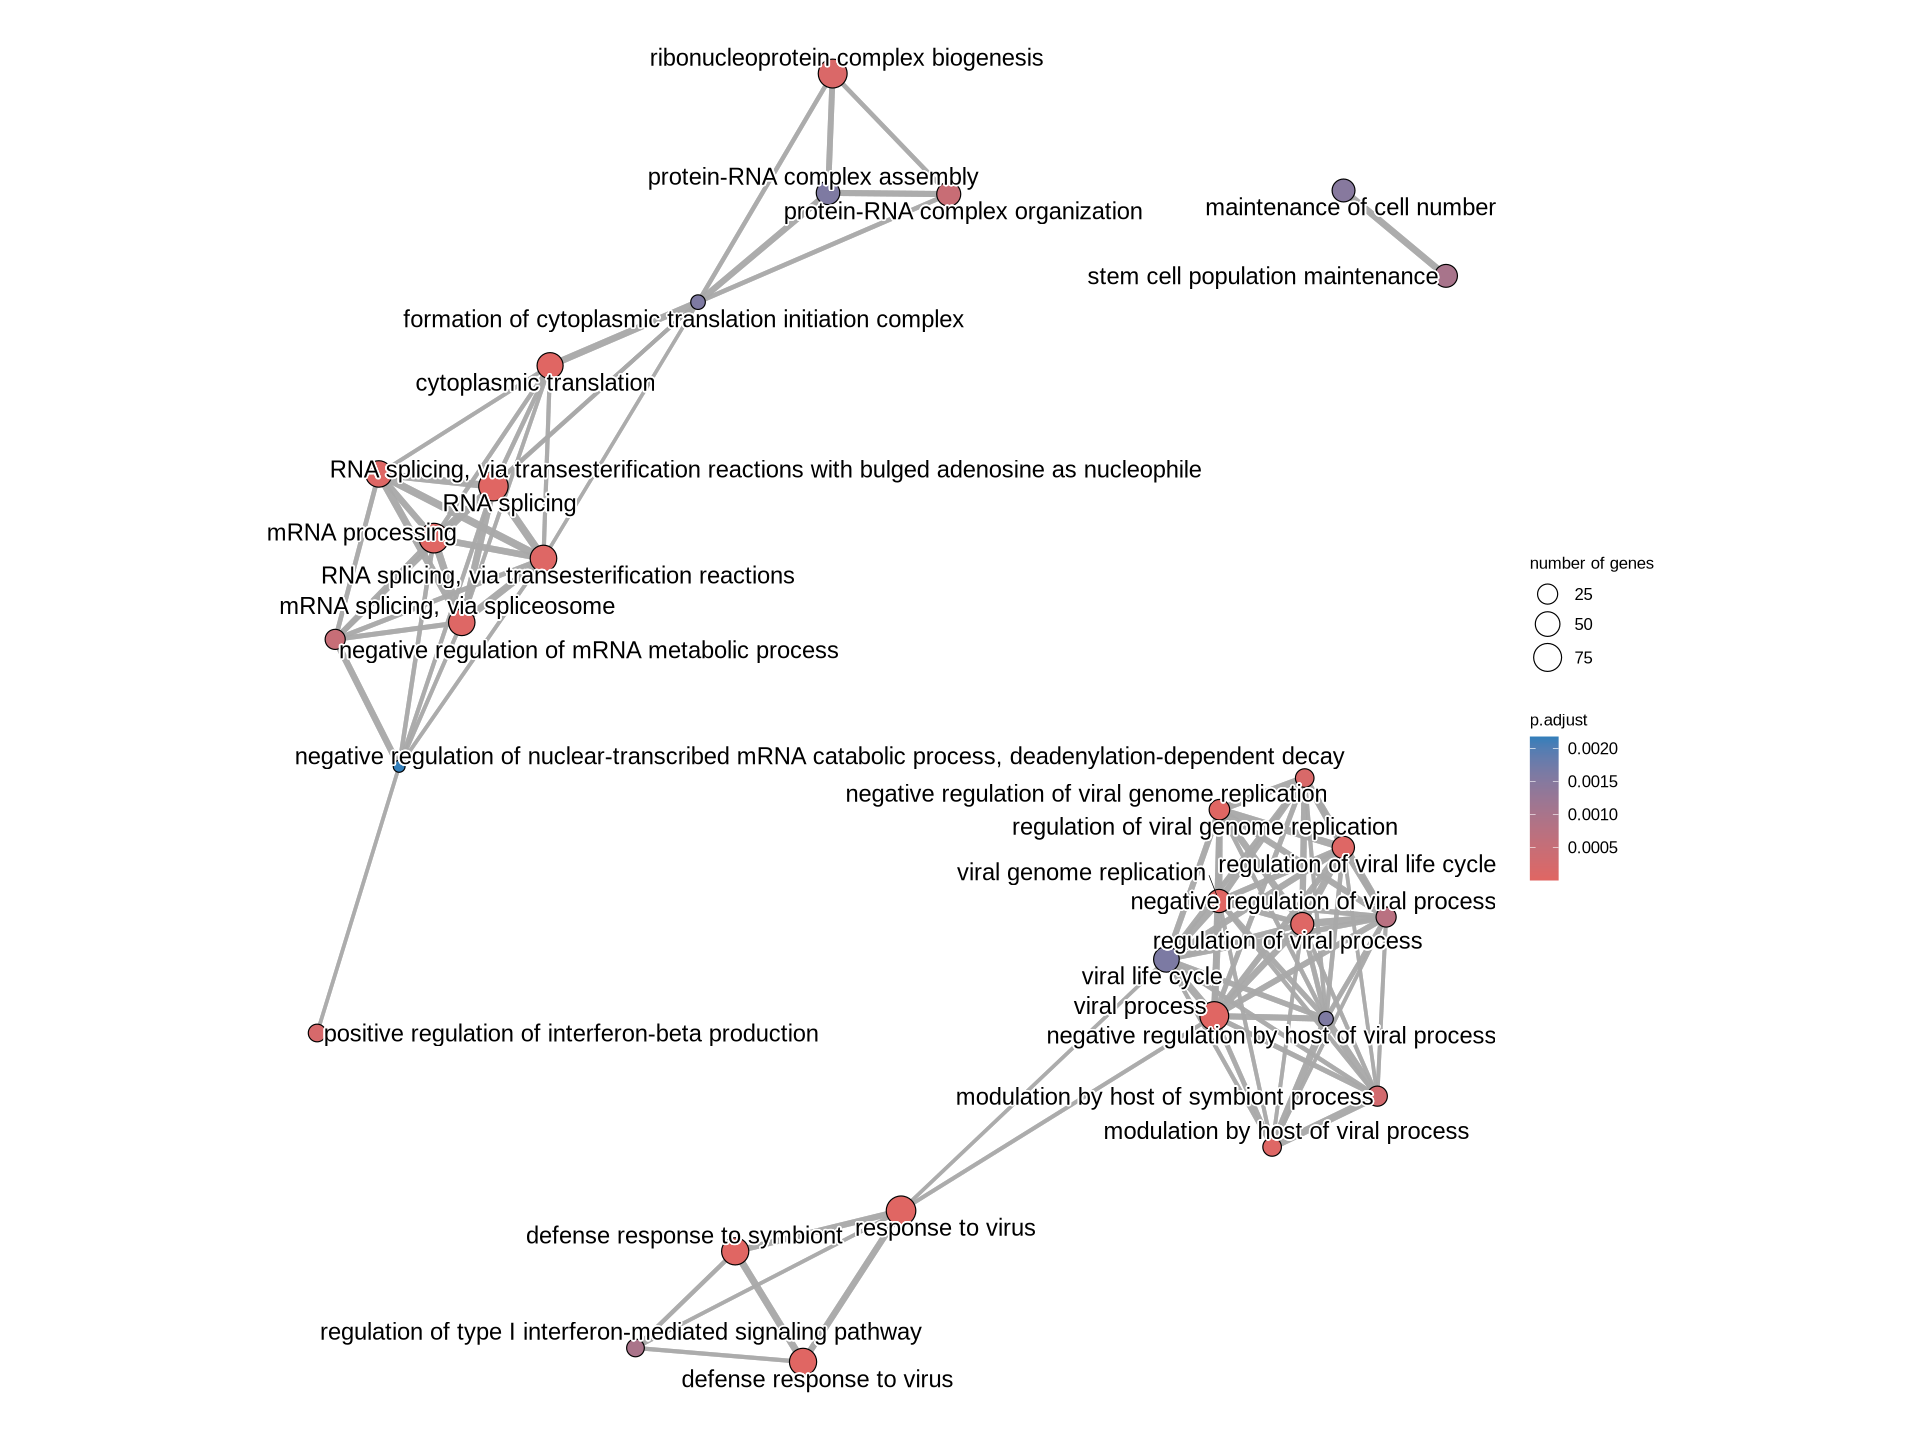

In [131]:
d <- godata('org.Hs.eg.db', ont="BP")
ego2 <- pairwise_termsim(ego, method="Wang", semData = d)
p<-emapplot(ego2)
options(repr.plot.width = 16, repr.plot.height = 12)
p